In [262]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
% matplotlib inline
import seaborn as sb
import mpld3 # interactive plots

In [263]:
random_seed = 42

## Utility function to drop duplicate columns

In [264]:
from pandas.core.common import array_equivalent

def remove_duplicate_cols(df):
    """http://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
    
    Use like:
    df = remove_duplicate_cols(df)
    
    If no duplicates, we return gracefully
    """
    Cols = list(df.columns)
    for i,item in enumerate(df.columns):
        if item in df.columns[:i]: Cols[i] = "toDROP"
    df.columns = Cols
    drop_cols = len([col for col in list(df.columns) if col == 'toDROP'])
    if drop_cols:
        return df.drop("toDROP", axis=1)
    else:
        return df

In [265]:
ls data/sequence_data/


DAL.devel.csv                LIWC_ipu.test.csv*
DAL.test.csv                 LIWC_ipu.train.csv*
DAL.train.csv                demo_neo_all.csv
DAL_ipu.devel.csv*           labeled_ipus_new.csv*
DAL_ipu.test.csv*            labeled_ipus_new.devel.csv
DAL_ipu.train.csv*           labeled_ipus_new.test.csv
IS13.devel.csv               labeled_ipus_new.train.csv
IS13.test.csv                labeled_turns.csv*
IS13.train.csv               labeled_turns_new.devel.csv*
IS13_ipu.devel.csv*          labeled_turns_new.test.csv*
IS13_ipu.test.csv*           labeled_turns_new.train.csv*
IS13_ipu.train.csv*          missing_ipus.csv
LIWC.devel.csv               missing_ipus.train.csv
LIWC.test.csv                missing_turns.csv
LIWC.train.csv               missing_turns.train.csv
LIWC_ipu.devel.csv*          wc


## Read in and Format the data

In [266]:
# load in data
all_train = pd.read_csv('data/all_train_normed.csv')
all_test = pd.read_csv('data/all_test_normed.csv')

In [267]:
all_train = all_train.fillna(0.0)

In [268]:
all_train.isnull().any().any()

False

In [269]:
all_test.isnull().any().any()
all_test =all_test.fillna(0.0)

In [270]:
# ### WRITE OUT FINAL CSVS ###
# all_train.to_csv('data/final_turns_train.csv')
# all_train.to_csv('data/final_turns_test.csv')

In [271]:
all_train = all_train.set_index(['person', 'turn'])
all_test = all_test.set_index(['person', 'turn'])

In [272]:
useless_cols = [ 'dur', 'start', 'end']
all_train = all_train.drop(useless_cols, axis=1)
all_test = all_test.drop(useless_cols, axis=1)

In [273]:
# drop the Praat features
praat_cols = ['minf0','maxf0','meanf0','medf0','stdvf0','masf0','mineng','maxeng','meaneng','stdveng','vcd2tot','jitter','shimmer']
all_train = all_train.drop(praat_cols, axis=1)
all_test = all_test.drop(praat_cols, axis=1)

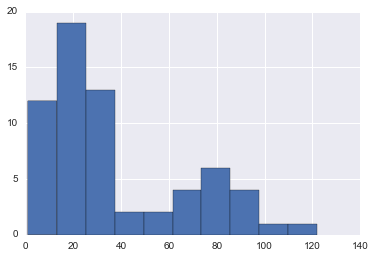

In [274]:
# number of ipus by pid
all_train.groupby(level=0).count()['text'].hist()

In [275]:
# label baselines for train and test
t, f = all_train['label'].value_counts()
train_base = max([t,f])/float(sum([t,f]))
print "Training baseline: %2.4f" % train_base

t, f = all_test['label'].value_counts()
test_base = max([t,f])/float(sum([t,f]))
print "Test baseline: %2.4f" % test_base
from sklearn.metrics import f1_score


class_names = ['Not Deceptive', 'Deceptive'] # 0 is truth, 1 is lie

Training baseline: 0.5328
Test baseline: 0.5659


In [276]:
all_train.head(1)

FunctionalWordPercent  mean_pleaseant  max_pleaseant  \
person turn                                                         
473    0                  0.145373        0.123632       0.713653   

             min_pleaseant  median_pleaseant  std_pleaseant  var_pleaseant  \
person turn                                                                  
473    0          0.157402           -0.1275      -0.360685      -0.471909   

             mean_activate  max_activate  min_activate     ...      \
person turn                                                ...       
473    0         -0.215365      0.842875     -0.445615     ...       

             LIWC_you_funcword  TotalWord  \
person turn                                 
473    0              0.012016   1.228886   

                                                          text  Ascore_raw  \
person turn                                                                  
473    0     UH THERE YOU KNOW THE WEST LAKE IS THE MOST IN...   -0.030104   

             Cscore_raw  Escore_raw  Gender  Language  Nscore_raw  Oscore_raw  
person turn                                                                    
473    0       0.032365    0.505112     0.0       1.0    0.055521   -0.807474  

[1 rows x 6531 columns]

In [277]:
noncovariates = ['label', 'text']
train_x = all_train.drop(noncovariates, axis=1).as_matrix()
train_y = all_train['label'].as_matrix()
test_x = all_test.drop(noncovariates, axis=1).as_matrix()
test_y = all_test['label'].as_matrix()

naive_f1 = f1_score(test_y, np.ones_like(test_y))
print naive_f1
feature_labels = list(all_train.drop(noncovariates, axis=1).columns.values)

print train_x.shape, test_x.shape

0.605421686747
(2365, 6529) (463, 6529)


In [278]:
np.any(np.isnan(train_x)), np.any(np.isnan(train_y))

(False, False)

In [279]:
np.any(np.isnan(test_x)), np.any(np.isnan(test_y))

(False, False)

In [280]:
def experiment(clf, param_grid, grid_metric='accuracy',
               train_x=train_x, train_y=train_y, 
               test_x=test_x, test_y=test_y, 
               label_names=class_names, cv=10):
    """Run GridSearchCv on the pipeline `clf` with `cv` number of folds over `grid`
    
    Then refit the best parameters on all of the train data, and analyze the test performance
    
    Performance metrics: accuracy, f1-score for Deceptive, confusion matrix
    
    NOTE: Specify parallel jobs in clf.  Won't do grid search in parallel.
    """
    print "Searching Grid..."
    grid = GridSearchCV(clf, param_grid, grid_metric, cv=cv, verbose=1)
    grid.fit(train_x, train_y)
    print "Fitting best estimator..."
    print "Chosen parameters: \n", grid.best_params_
    print "Best Estimator: \n", grid.best_estimator_
    clf.set_params(**grid.best_params_)
    clf.fit(train_x, train_y)
    print "Evaluating on Test..."
    preds = clf.predict(test_x)
    acc = accuracy_score(test_y, preds)
    p = precision_score(test_y, preds)
    r = recall_score(test_y, preds)
    f1 = f1_score(test_y, preds)
    print "Test Accuracy: %1.4f, Test F1: %1.4f (P:%0.2f R:%0.2f)" % (acc, f1, p, r)
    confusion_matrix = cm(test_y, preds)
    results = {'clf': clf,
               'best_params':grid.best_params_,
               'grid_scores':grid.grid_scores_,
               'acc':acc,
               'f1':f1, 'precision':p, 'recall':r,
               'cm':confusion_matrix}
    return results

def plot_confusion_matrix(cm, label_names=class_names, save_name=None, 
                          title='Normed Confusion matrix', 
                          cmap=plt.cm.Blues, 
                          stats=None):
    """Take confusion matrix, label names and plot a very nice looking confusion matrix
    Args:
        cm: a confustion matrix w/ prediction rows and true columns
        label_names: list of class names for tick labels
        save_name (optional): if provided, save the figure to this location
        title (optional): the desired title
        cmap (optional): the colormap to display cell magnitudes with
        stats (optional): if stats, label class precisions and macro stats
    """
    fig, ax = plt.subplots(figsize=(6,6))
    
    # calc normalized cm
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    
    # print nonzero raw counts
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        norm = cm_normalized[x_val, y_val]
        c = "%i" % (cm.astype('int')[x_val, y_val])
        if norm > 0.0:
            color = 'white' if norm > .5 else 'black'
            ax.text(y_val, x_val, c, va='center', ha='center', color=color, fontsize=14)
    
    # actual plot
    im = ax.imshow(cm_normalized, interpolation='nearest', origin='upper', cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # set ticks and offset grid
    tick_marks = np.arange(len(label_names))
    tick_marks_offset = np.arange(len(label_names)) - .5
    ax.set_xticks(tick_marks, minor=False)
    ax.set_yticks(tick_marks, minor=False)
    ax.set_xticks(tick_marks_offset, minor=True)
    ax.set_yticks(tick_marks_offset, minor=True)
    ax.grid(which='minor')
    if stats:
        # include micro precisio, recall, and f1
        aug_y_labels = []
        for i in range(len(label_names)):
            aug = ("%s\nP:%0.2f, R:%0.2f, F1:%0.2f" 
                   % (label_names[i],
                      stats['class_precision'][i],
                      stats['class_recall'][i],
                      stats['class_f1'][i],))
            aug_y_labels.append(aug)
    else:
        aug_y_labels = label_names
    ax.set_xticklabels(label_names, horizontalalignment='left')
    ax.set_yticklabels(aug_y_labels)
    
    # other stuff
    plt.tight_layout()
    plt.ylabel('Predicted Labels', fontsize=16)
    if stats:
        # include macro 
        aug_x_label = ("True Labels\n Micro P:%0.2f, R:%0.2f, F1:%0.2f\n Macro P:%0.2f, R:%0.2f, F1:%0.2f" 
                       % (stats['micro_precision'], stats['micro_recall'], stats['micro_f1'],
                          stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    else:
        aug_x_label = "True Label"
    plt.xlabel(aug_x_label, fontsize=16)
    plt.title(title, fontsize=18)
    if save_name:
        plt.savefig(save_name+'.pdf')
        
def plot_grid_scores(grid_scores, baseline=train_base):
    """Take grid scores and plot interactive box and whisker plot with baseline reference"""
    # determine endpoint of baseline
    cv_scores = [s[2] for s in grid_scores] # 2 is cross val scores
    labels = ["\n".join([str(val) for val in s[0].values()]) for s in grid_scores]
    x_label = ", ".join([str(key) for key in grid_scores[0][0].keys()])
    fig, ax = plt.subplots(figsize=(15,6))
    boxes = ax.boxplot(cv_scores)
    ax.hlines([baseline], [0], [len(grid_scores) + 1], linestyles='dashed', label='Baseline Accuracy')
    
    plt.legend(loc='best')
    ax.set_title("Cross Validation Scores")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel(x_label)
    ax.set_xticklabels(labels, fontsize=8)
    plt.show()

In [281]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report as report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as cm

# Random Forest w/o pre-feature selection

In [45]:
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid =dict(n_estimators=[200],#[5, 10, 50, 100, 200, 300], 
                 criterion=['entropy'],
                 max_features=[10],#['log2', 'sqrt']
#                  max_depth=None, 
#                  min_samples_split=2, 
#                  min_samples_leaf=1, 
#                  min_weight_fraction_leaf=0.0, 
#                  max_features=['auto', 10], 
#                  max_leaf_nodes=None, 
#                  bootstrap=True, 
#                  oob_score=False, 
#                  n_jobs=1, 
#                  random_state=None, 
#                  verbose=0, 
#                  warm_start=False, 
#                  class_weight=None
                )
rf_results = experiment(rf, param_grid, cv=5)


Searching Grid...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.0s finished


Fitting best estimator...
Chosen parameters: 
{'max_features': 10, 'n_estimators': 200, 'criterion': 'entropy'}
Best Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.6134, Test F1: 0.4929 (P:0.57 R:0.43)


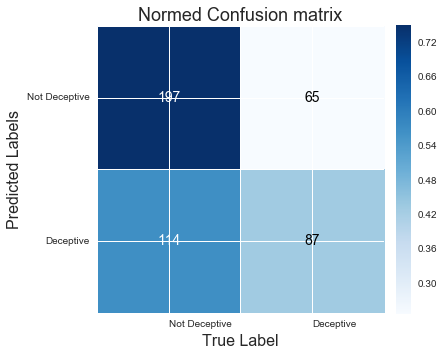

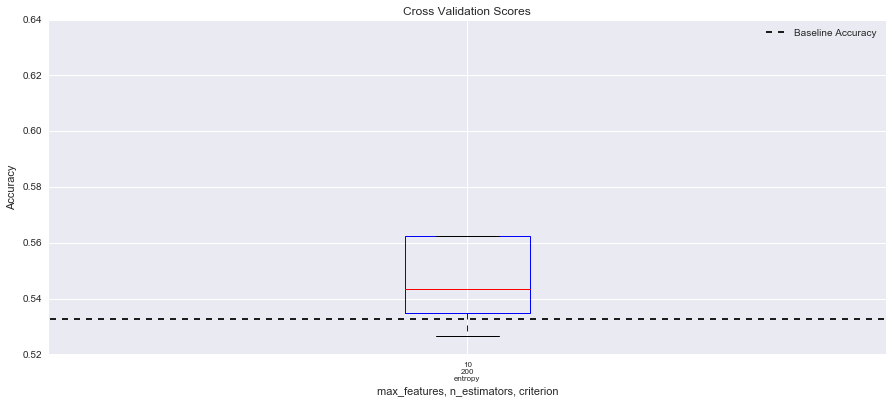

In [48]:
plot_confusion_matrix(rf_results['cm'])
plot_grid_scores(rf_results['grid_scores'])

In [47]:
imports = sorted(zip(feature_labels, rf_results['clf'].feature_importances_), key=lambda x:x[1], reverse=True)
for l, f in imports[:20]:
    print "%2.4f : %s" % (f,l)

0.0005 : pcm_Mag_spectralRollOff50.0_sma_percentile1.0
0.0005 : mfcc_sma[3]_meanSegLen
0.0004 : audspec_lengthL1norm_sma_peakRangeRel
0.0004 : audSpec_Rfilt_sma_de[1]_meanPeakDist
0.0004 : audSpec_Rfilt_sma_de[5]_pctlrange0-1
0.0004 : mfcc_sma[9]_lpc4
0.0004 : audSpec_Rfilt_sma[14]_meanPeakDist
0.0004 : mfcc_sma_de[10]_peakRangeAbs
0.0004 : audSpec_Rfilt_sma_de[13]_peakMeanRel
0.0004 : mfcc_sma_de[1]_kurtosis
0.0004 : F0final_sma_centroid
0.0004 : voicingFinalUnclipped_sma_minPos
0.0004 : std_imagery
0.0004 : pcm_Mag_spectralKurtosis_sma_meanPeakDist
0.0004 : mfcc_sma[11]_peakMeanRel
0.0004 : mfcc_sma[2]_maxSegLen
0.0004 : audSpec_Rfilt_sma_de[1]_upleveltime25
0.0004 : var_activate
0.0004 : pcm_Mag_spectralFlux_sma_kurtosis
0.0004 : pcm_Mag_harmonicity_sma_minRangeRel


In [55]:
from sklearn.linear_model import LogisticRegression as LR
Cs = np.logspace(-8,-4,4)
lr = LR(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid = dict(
                  penalty=['l2'], 
#                   dual=False, 
#                   tol=0.0001, 
                  C=Cs, 
#                   fit_intercept=True, 
#                   intercept_scaling=1, 
#                   class_weight=None, 
#                   random_state=random_seed, 
#                   solver='liblinear', 
#                   max_iter=100, 
#                   multi_class='ovr', 
#                   verbose=0, 
#                   warm_start=False, 
#                   n_jobs=1
                 )
lr_all_results = experiment(lr, param_grid, cv=5)

Searching Grid...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   16.5s finished


Fitting best estimator...
Chosen parameters: 
{'penalty': 'l2', 'C': 1e-08}
Best Estimator: 
LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.5961, Test F1: 0.5798 (P:0.53 R:0.64)


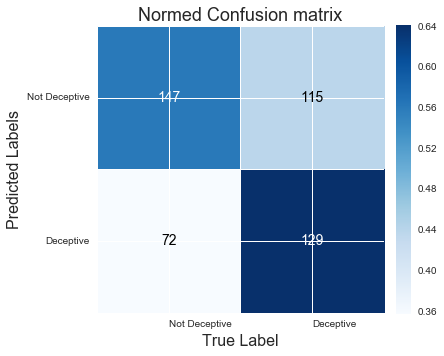

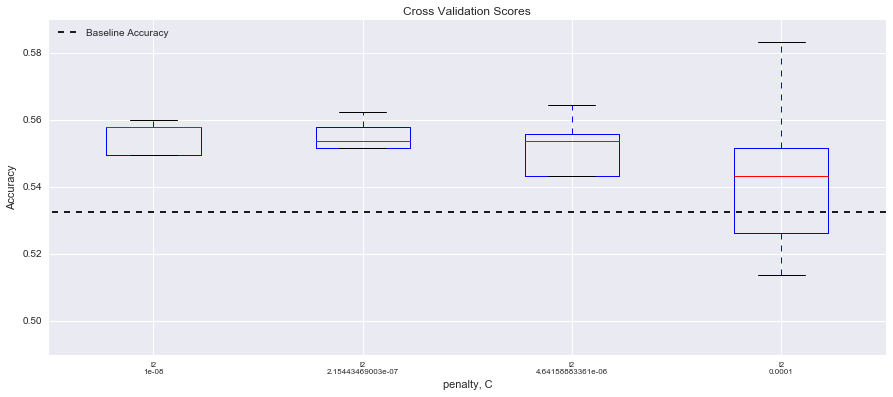

In [56]:
plot_confusion_matrix(lr_all_results['cm'])
plot_grid_scores(lr_all_results['grid_scores'])

## SVM

In [340]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=random_seed, verbose=5, loss='hinge')
param_grid = dict(C=np.logspace(-4,1,6), 
#                   kernel=['linear'], 
#                   degree=3, 
#                   gamma='auto', 
#                   coef0=0.0, 
#                   shrinking=True, 
#                   probability=False, 
#                   tol=0.001, 
#                   cache_size=200, 
#                   class_weight=None, 
#                   verbose=False, 
#                   max_iter=-1, 
#                   decision_function_shape=None, 
#                   random_state=random_seed
                 )
svm_results = experiment(svm, param_grid, cv=5)


Searching Grid...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.8min finished


[LibLinear]Fitting best estimator...
Chosen parameters: 
{'C': 0.0001}
Best Estimator: 
LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=5)
[LibLinear]Evaluating on Test...
Test Accuracy: 0.5572, Test F1: 0.5176 (P:0.49 R:0.55)


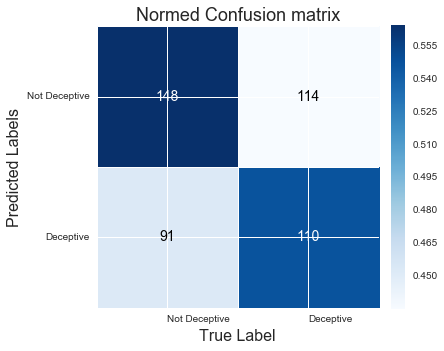

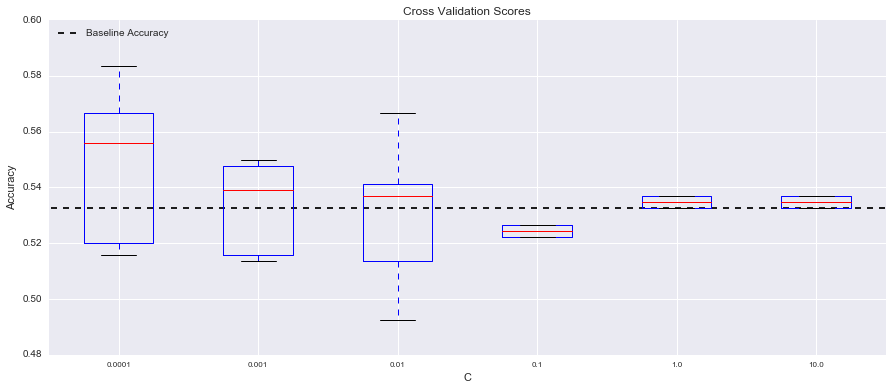

In [341]:
plot_confusion_matrix(svm_results['cm'])
plot_grid_scores(svm_results['grid_scores'])

In [342]:
from sklearn.svm import SVC

svm = SVC(random_state=random_seed)
param_grid = dict(C=np.logspace(-8,-3,5), 
                  kernel=['rbf'], 
#                   degree=3, 
#                   gamma='auto', 
#                   coef0=0.0, 
#                   shrinking=True, 
#                   probability=False, 
#                   tol=0.001, 
#                   cache_size=200, 
#                   class_weight=None, 
#                   verbose=False, 
#                   max_iter=-1, 
#                   decision_function_shape=None, 
#                   random_state=random_seed
                 )
svm_results = experiment(svm, param_grid, cv=5)


Searching Grid...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 13.6min finished


Fitting best estimator...
Chosen parameters: 
{'kernel': 'rbf', 'C': 1e-08}
Best Estimator: 
SVC(C=1e-08, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
Evaluating on Test...
Test Accuracy: 0.5659, Test F1: 0.0000 (P:0.00 R:0.00)


In [ ]:
plot_confusion_matrix(svm_results['cm'])
plot_grid_scores(svm_results['grid_scores'])

In [ ]:
from sklearn.svm import SVC

svm = SVC(random_state=random_seed)
param_grid = dict(C=np.logspace(-4,4,9), 
                  kernel=['poly'], 
#                   degree=3, 
#                   gamma='auto', 
#                   coef0=0.0, 
#                   shrinking=True, 
#                   probability=False, 
#                   tol=0.001, 
#                   cache_size=200, 
#                   class_weight=None, 
#                   verbose=False, 
#                   max_iter=-1, 
#                   decision_function_shape=None, 
#                   random_state=random_seed
                 )
svm_results = experiment(svm, param_grid, cv=5)


In [347]:
from sklearn.ensemble import AdaBoostClassifier

base = LR(C=1e-3, solver='lbfgs')
adaboost = AdaBoostClassifier(base, n_estimators=50, learning_rate=1.0, random_state=random_seed)
param_grid = dict(n_estimators=[10,50, 100],
                 learning_rate=[.1, 1., 10.])
ada_results = experiment(adaboost, param_grid, cv=5)

Searching Grid...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  8.7min finished


Fitting best estimator...
Chosen parameters: 
{'n_estimators': 50, 'learning_rate': 1.0}
Best Estimator: 
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=42)
Evaluating on Test...
Test Accuracy: 0.6112, Test F1: 0.4737 (P:0.57 R:0.40)


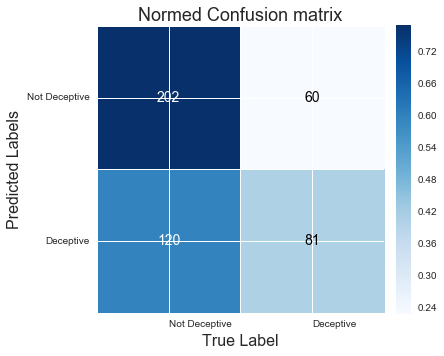

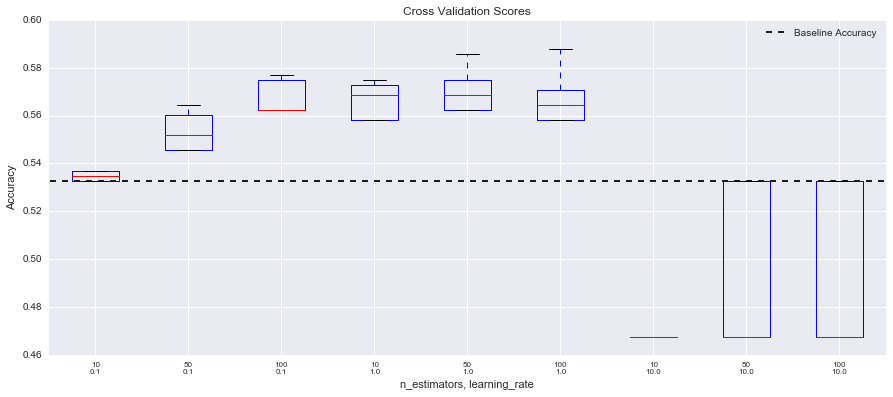

In [348]:
plot_confusion_matrix(ada_results['cm'])
plot_grid_scores(ada_results['grid_scores'])

## Per person feature selection with LassoCV

In [26]:
train_pids = all_train.index.get_level_values(level=0).unique()

In [31]:
from sklearn.linear_model import LogisticRegressionCV as LRCV
train_pids = all_train.index.get_level_values(level=0).unique()

In [100]:
lrs = {}
for i, pid in enumerate(train_pids):
    lrcv = LRCV(penalty='l1', n_jobs=-1, refit=False, random_state=random_seed, solver='liblinear')
    X = all_train[all_train.index.get_level_values('pid') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('pid') == pid]['label'].as_matrix()
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
    lrcv.fit(X, y)
    lrs[pid] = lrcv

0 :: PID: 205, n: 134
1 :: PID: 210, n: 86
2 :: PID: 213, n: 39
3 :: PID: 212, n: 31
4 :: PID: 225, n: 70
5 :: PID: 216, n: 34
6 :: PID: 221, n: 79
7 :: PID: 220, n: 117
8 :: PID: 236, n: 122
9 :: PID: 224, n: 42
10 :: PID: 229, n: 41
11 :: PID: 226, n: 113
12 :: PID: 228, n: 51
13 :: PID: 231, n: 59
14 :: PID: 230, n: 61
15 :: PID: 237, n: 101
16 :: PID: 243, n: 87
17 :: PID: 242, n: 39
18 :: PID: 245, n: 36
19 :: PID: 244, n: 40
20 :: PID: 248, n: 91
21 :: PID: 246, n: 80
22 :: PID: 249, n: 60
23 :: PID: 257, n: 113
24 :: PID: 253, n: 62
25 :: PID: 252, n: 107
26 :: PID: 255, n: 158
27 :: PID: 254, n: 84
28 :: PID: 279, n: 49
29 :: PID: 256, n: 114
30 :: PID: 261, n: 79
31 :: PID: 260, n: 93
32 :: PID: 263, n: 51
33 :: PID: 262, n: 45
34 :: PID: 264, n: 54
35 :: PID: 265, n: 96
36 :: PID: 269, n: 55
37 :: PID: 268, n: 47
38 :: PID: 271, n: 39
39 :: PID: 270, n: 39
40 :: PID: 273, n: 66
41 :: PID: 272, n: 36
42 :: PID: 274, n: 146
43 :: PID: 277, n: 144
44 :: PID: 278, n: 58
45 :: PID

In [34]:
lrs.values()

[LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
            refit=True, scoring=None, solver='liblinear', tol=0.0001,
            verbose=2),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
            refit=True, scoring=None, solver='liblinear', tol=0.0001,
            verbose=2),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
            refit=True, scoring=None, solver='liblinear', tol=0.0001,
            verbose=2),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_

In [41]:
path = lrs.values()[0].coefs_paths_[1]
path.shape

(3, 10, 6530)

In [42]:
avg = np.mean(path, axis=0)
avg.shape

(10, 6530)

 ...]

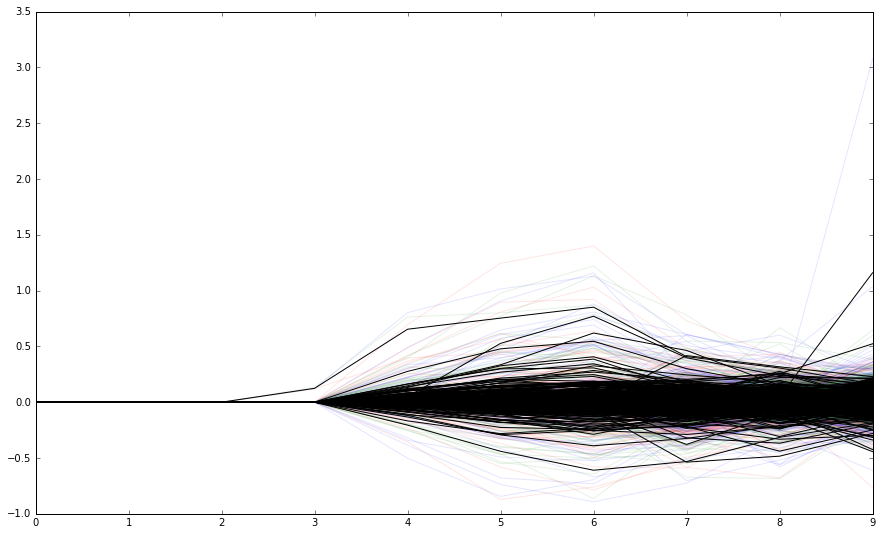

In [52]:
fig, ax = plt.subplots(figsize=(15,9))
colors = ['r', 'b', 'g']
for i in range(3):
    plt.plot(path[i,:,:], color=colors[i], alpha=.1)
plt.plot(avg, color='k')

In [78]:
b = lrs.values()[0].coef_.reshape(-1)
len(b)

6529

In [101]:
betas = np.concatenate([v.coef_ for v in lrs.values()])
betas.shape

(111, 6529)

(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 29)


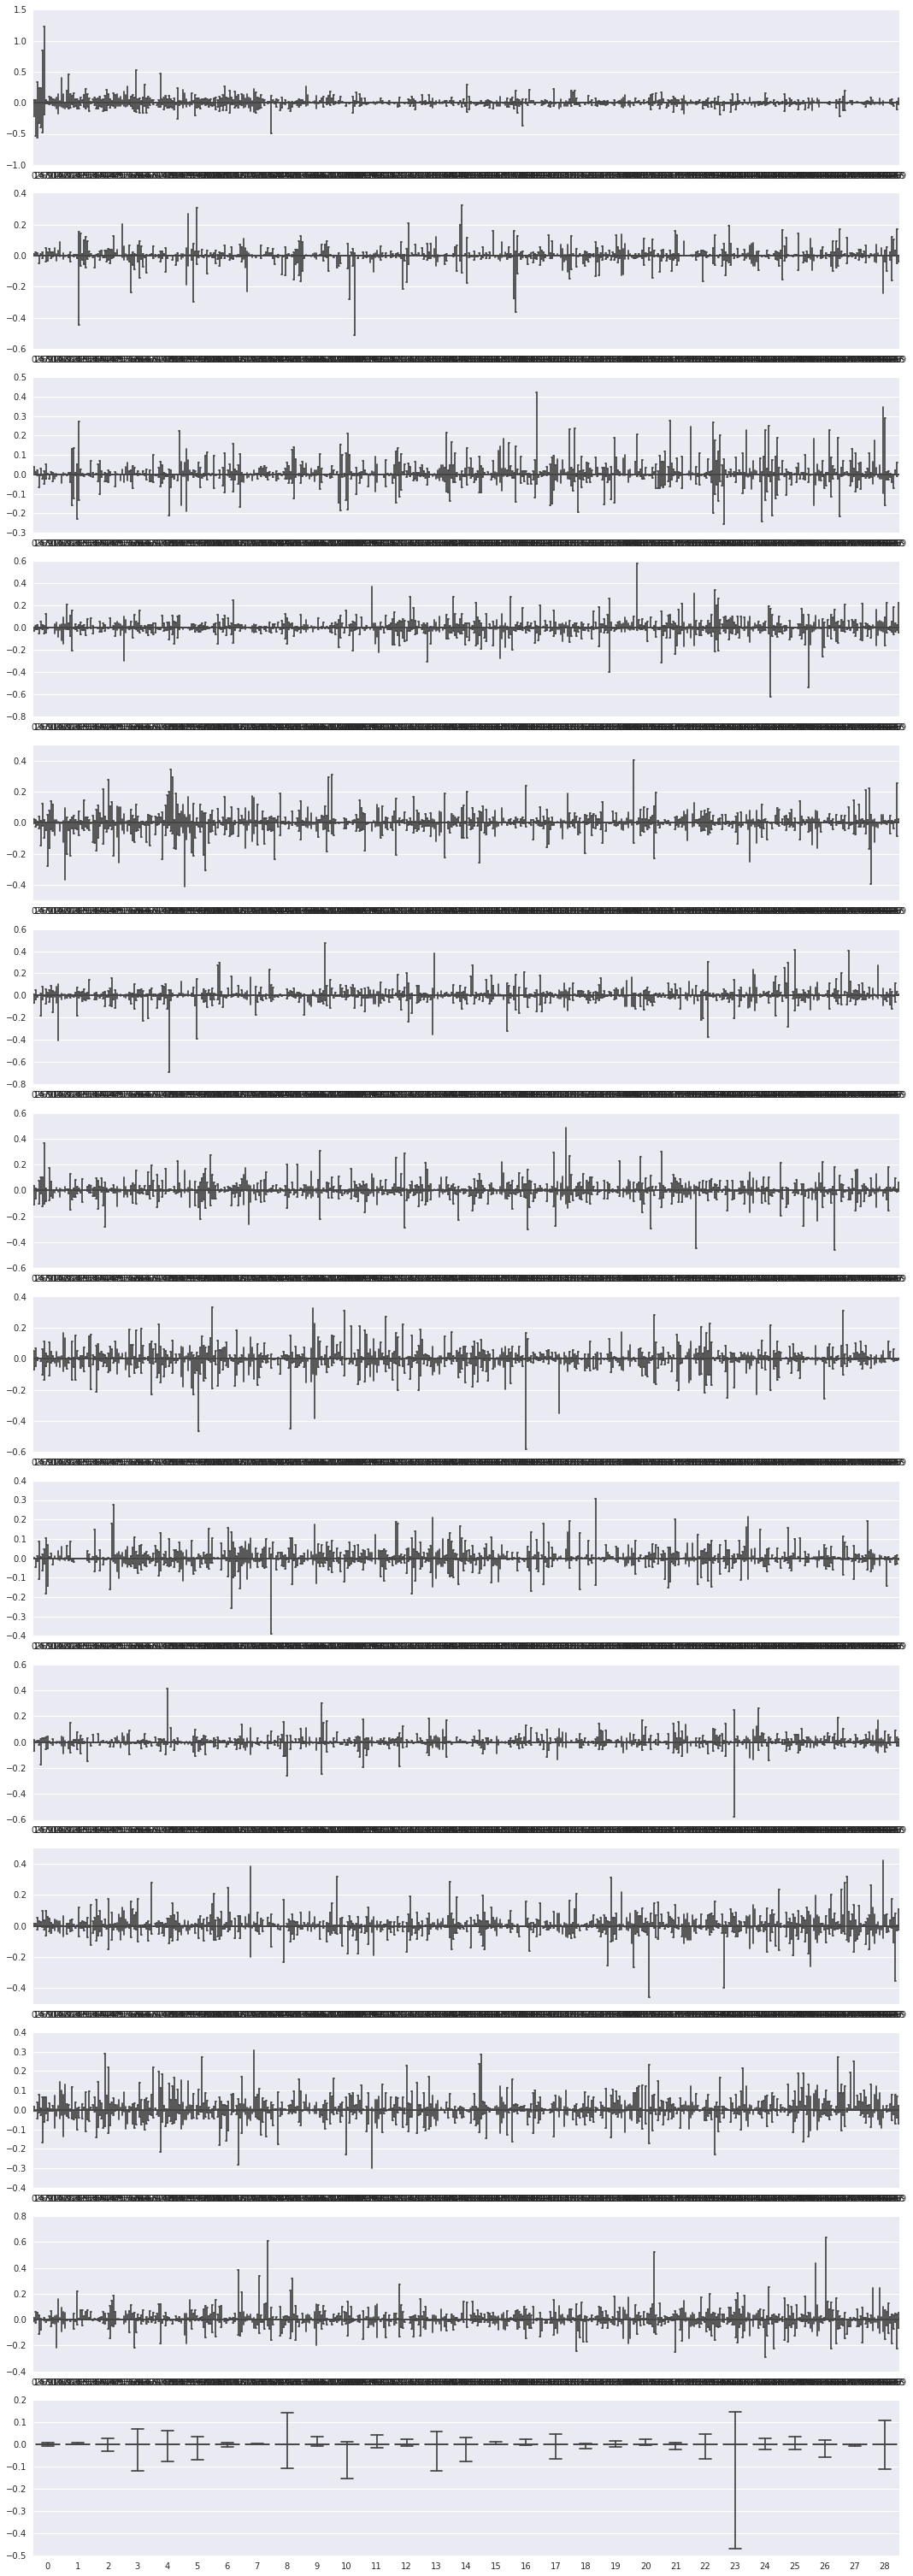

In [102]:
stride = 500
num_plots = betas.shape[1] // stride + 1
fig, ax = plt.subplots(num_plots,1, figsize=(15,3*num_plots))
for i in range(num_plots):
    minibetas = betas[:,i*stride:(i+1)*stride]
    print minibetas.shape
    sb.boxplot(data=minibetas, ax=ax[i])
plt.tight_layout()

In [103]:
# proportion that are allzeros
nonzero_betas = len([v.coef_ for v in lrs.values() if np.sum(v.coef_) > 0.0])
nonzero_betas, len(lrs.values()), nonzero_betas/float(len(lrs.values()))

(59, 111, 0.5315315315315315)

### Signal appears to be sparse, and highly variable across people

## Stability analysis across all training people

In [353]:
from sklearn.linear_model import RandomizedLogisticRegression as RLR
from sklearn.linear_model import lasso_stability_path

# supress all warnings because thise package is old and things have been deprecated
import warnings
warnings.filterwarnings('ignore')

In [354]:
Cs = np.logspace(-4,5,10)
all_rlr = RLR(C=Cs,
          scaling=.5,
          sample_fraction=.2,#.75, 
          n_resampling=100,
          selection_threshold=.5,#.75,
          normalize=False,
          random_state=random_seed,
          n_jobs=1,
          verbose=5)
%time all_rlr.fit(train_x, train_y)
print "DONE"

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:   22.6s
[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:  1.5min


CPU times: user 1min 55s, sys: 12.3 s, total: 2min 7s
Wall time: 2min 8s
DONE


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished


In [355]:
c_idx = list(Cs).index(10)

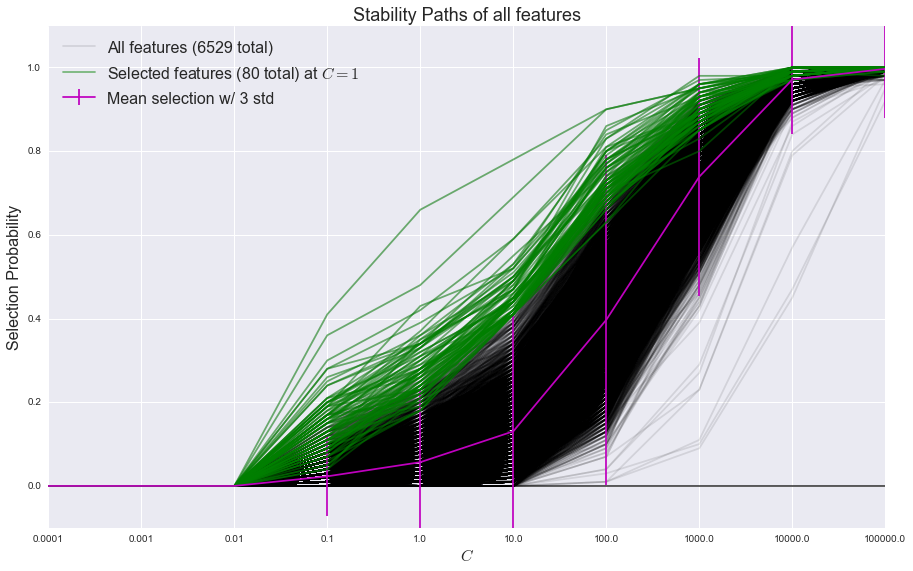

In [356]:
scores =all_rlr.all_scores_
avg = np.mean(scores.T, axis=1)
std = np.std(scores.T, axis=1)

# get the scores that are greater than 3 stddevs above average in at least one experiment
num_std = 3
thresh = avg + num_std*std
select_mask = scores[:, c_idx] > thresh[c_idx]
# print select_mask[:150]
above = scores[select_mask]
# print rlr.all_scores_.T.shape, above.shape

fig, ax = plt.subplots(1,1, figsize=(15,9))
ax.grid(zorder=0)
s = ax.plot(scores.T, 'k', alpha=.1, zorder=1, label=('All features (%i total)'%scores.shape[0]))
a = ax.plot(above.T, 'g', alpha=.5, label=('Selected features (%i total) at $C=1$'%above.shape[0]))
ax.set_xticks(range(len(Cs)))
ax.set_xticklabels(Cs)
e = ax.errorbar(range(len(Cs)), avg, yerr=num_std*std, color='m', ecolor='m', zorder=2, label='Mean selection w/ 3 std')
ax.set_title("Stability Paths of all features", fontsize=18)
ax.set_xlabel('$C$', fontsize=16)
ax.set_ylim(-.1, 1.1)
ax.set_ylabel('Selection Probability', fontsize=16)
ax.legend(handles=[s[0], a[0], e], loc='best', fontsize=16)
plt.savefig('all_stablity.png')

In [68]:
mean_scores = np.mean(all_rlr.all_scores_, axis=1)
c_scores = all_rlr.all_scores_[:,c_idx]

In [69]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
colors = ['b', 'r', 'g', 'm']
# sizes = np.cumsum([0, 
#          neo['train'].shape[1]-2,
#          liwc['train'].shape[1]-6,
#          dal['train'].shape[1]-3,
#          is13['train'].shape[1]-3])
sets = ['Neo', 'LIWC', 'DAL', 'OpenSmile']
labels = list(all_train.drop(noncovariates, axis=1).columns.values)


# print labels[:200]

scatter = ax.scatter(range(len(mean_scores)), mean_scores, alpha=.5, color='b')

tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
    
# l = ax.legend(fancybox=0)
ax.set_title('Mean Selection Probabilities')
# for i, text in enumerate(l.get_texts()):
#     text.set_color(colors[i])
mpld3.display()

0.259107060806


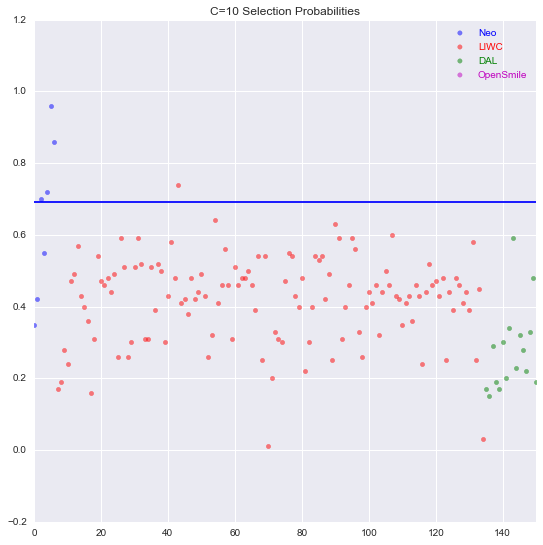

In [214]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
colors = ['b', 'r', 'g', 'm']
sizes = np.cumsum([0, 
         neo['train'].shape[1]-2,
         liwc['train'].shape[1]-6,
         dal['train'].shape[1]-3,
         is13['train'].shape[1]-3])
sets = ['Neo', 'LIWC', 'DAL', 'OpenSmile']
labels = list(all_train.drop(noncovariates, axis=1).columns.values)
# print labels[:200]
for i in range(len(sizes)-1):
    left = sizes[i]
    right = sizes[i+1]
    scatter = ax.scatter(range(left, right), c_scores[left:right], alpha=.5, color=colors[i], label=sets[i])

#     tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels[left:right])
#     mpld3.plugins.connect(fig, tooltip)
    
a = avg[c_idx]
print a
s = std[c_idx]
ax.axhline(y=a+3*s, xmin=0, xmax=7000)    
ax.set_xlim(0,150)
l = ax.legend(fancybox=0)
ax.set_title('C=10 Selection Probabilities')
for i, text in enumerate(l.get_texts()):
    text.set_color(colors[i])
# mpld3.display()

### Now fit Ridge Regression w/  and w/o stability selected features

In [357]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid = dict(
                  penalty=['l2'], 
#                   dual=False, 
#                   tol=0.0001, 
                  C=[1000],#Cs, 
#                   fit_intercept=True, 
#                   intercept_scaling=1, 
#                   class_weight=None, 
#                   random_state=random_seed, 
#                   solver='liblinear', 
#                   max_iter=100, 
#                   multi_class='ovr', 
#                   verbose=0, 
#                   warm_start=False, 
#                   n_jobs=1
                 )

print select_mask
sm_train_x = train_x[:,select_mask]
sm_test_x = test_x[:, select_mask]
print sm_train_x.shape
lr2_results = experiment(lr, param_grid,
                         train_x=sm_train_x, 
                         test_x=sm_test_x, cv=5)

[False False False ..., False  True False]
(2365, 80)
Searching Grid...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting best estimator...
Chosen parameters: 
{'penalty': 'l2', 'C': 1000}
Best Estimator: 
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.4838, Test F1: 0.4747 (P:0.43 R:0.54)


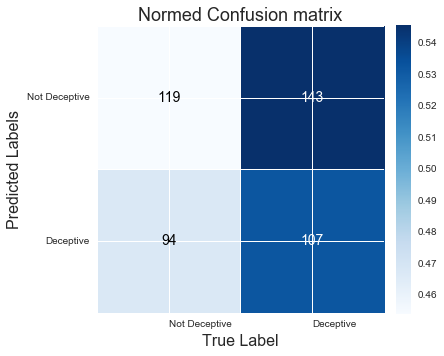

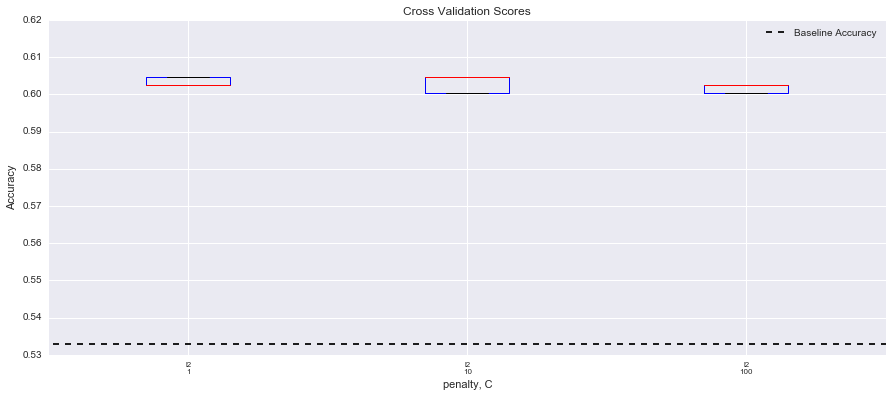

In [183]:
plot_confusion_matrix(lr2_results['cm'])
plot_grid_scores(lr2_results['grid_scores'])

In [89]:
lr = LR(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid = dict(
                  penalty=['l2'], 
#                   dual=False, 
#                   tol=0.0001, 
                  C=[.01, .1, 1, 10, 100],#Cs, 
#                   fit_intercept=True, 
#                   intercept_scaling=1, 
#                   class_weight=None, 
#                   random_state=random_seed, 
#                   solver='liblinear', 
#                   max_iter=100, 
#                   multi_class='ovr', 
#                   verbose=0, 
#                   warm_start=False, 
#                   n_jobs=1
                 )
lr_all_results = experiment(lr, param_grid, cv=5)

Searching Grid...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.8min finished


Fitting best estimator...
Chosen parameters: 
{'penalty': 'l2', 'C': 100}
Best Estimator: 
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.5097, Test F1: 0.4853 (P:0.45 R:0.53)


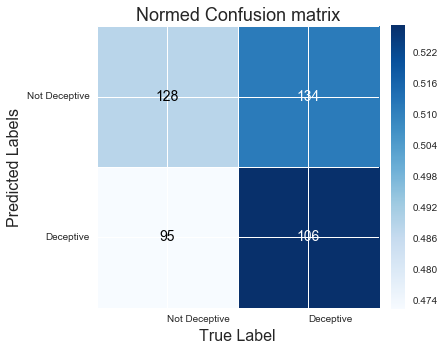

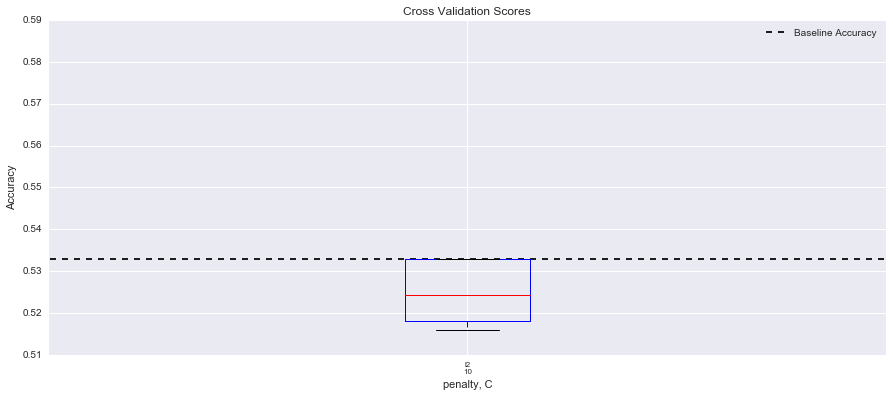

In [73]:
plot_confusion_matrix(lr_all_results['cm'])
plot_grid_scores(lr_all_results['grid_scores'])

In [358]:
imports = sorted(zip(list(np.array(feature_labels)[select_mask]), 
                     list(lr2_results['clf'].coef_.reshape(-1))), 
                 key=lambda x:x[1], reverse=True)
for i, (l, f) in enumerate(imports[:10]+imports[-10:]):
    print "%i :: %2.4f : %s" % (i, f,l)

0 :: 8.1807 : pcm_Mag_psySharpness_sma_de_minRangeRel
1 :: 0.4640 : LIWC_cogmech
2 :: 0.4137 : pcm_Mag_spectralRollOff50.0_sma_percentile1.0
3 :: 0.2774 : pcm_Mag_spectralKurtosis_sma_de_meanSegLen
4 :: 0.2014 : pcm_Mag_spectralRollOff75.0_sma_percentile1.0
5 :: 0.1870 : pcm_Mag_spectralEntropy_sma_de_peakRangeRel
6 :: 0.1568 : pcm_Mag_spectralKurtosis_sma_de_minRangeRel
7 :: 0.1448 : LIWC_health
8 :: 0.1437 : mfcc_sma[5]_risetime
9 :: 0.1414 : mfcc_sma[2]_centroid
10 :: -0.1255 : audSpec_Rfilt_sma_de[16]_segLenStddev
11 :: -0.1295 : Ascore_raw
12 :: -0.1315 : voicingFinalUnclipped_sma_de_upleveltime50
13 :: -0.1350 : mfcc_sma[9]_peakMeanRel
14 :: -0.1478 : mfcc_sma[7]_minPos
15 :: -0.1518 : audSpec_Rfilt_sma_de[13]_peakMeanRel
16 :: -0.1623 : audSpec_Rfilt_sma_de[14]_peakMeanRel
17 :: -0.2674 : pcm_Mag_spectralRollOff25.0_sma_percentile1.0
18 :: -0.6048 : LIWC_cogmech_funcword
19 :: -8.0065 : pcm_Mag_spectralCentroid_sma_de_minRangeRel


In [66]:
all_imports = sorted(zip(feature_labels, list(lr_all_results['clf'].coef_.reshape(-1))), key=lambda x:x[1], reverse=True)
for l, f in all_imports[:20]:
    print "%2.4f : %s" % (f,l)

2.3726 : pcm_zcr_sma_linregc1
2.3515 : pcm_Mag_harmonicity_sma_de_meanSegLen
2.2154 : pcm_Mag_fband250-650_sma_de_peakRangeAbs
2.1410 : audspec_lengthL1norm_sma_minSegLen
2.1079 : pcm_Mag_harmonicity_sma_qregc1
2.0465 : jitterLocal_sma_de_quartile1
2.0438 : pcm_Mag_spectralEntropy_sma_de_peakRangeAbs
2.0274 : mfcc_sma_de[9]_upleveltime25
2.0157 : jitterDDP_sma_upleveltime50
2.0018 : audSpec_Rfilt_sma_de[16]_lpgain
1.9997 : pcm_Mag_spectralKurtosis_sma_de_upleveltime25
1.9888 : audSpec_Rfilt_sma[10]_quartile1
1.9812 : audSpec_Rfilt_sma_de[0]_percentile1.0
1.9732 : pcm_Mag_spectralFlux_sma_percentile1.0
1.9641 : audspec_lengthL1norm_sma_de_posamean
1.9172 : pcm_Mag_spectralEntropy_sma_de_lpgain
1.9072 : pcm_Mag_spectralSlope_sma_de_iqr1-2
1.8924 : pcm_Mag_harmonicity_sma_range
1.8719 : audSpec_Rfilt_sma_de[21]_posamean
1.8173 : LIWC_assent


## Random Forest with stability selectiom

In [170]:
# RF with preselcted by sta
rf = RF(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid =dict(n_estimators=[200],#[5, 10, 50, 100, 200, 300], 
                 criterion=['entropy'],
                 max_features=[10],#['log2', 'sqrt']
#                  max_depth=None, 
#                  min_samples_split=2, 
#                  min_samples_leaf=1, 
#                  min_weight_fraction_leaf=0.0, 
#                  max_features=['auto', 10], 
#                  max_leaf_nodes=None, 
#                  bootstrap=True, 
#                  oob_score=False, 
#                  n_jobs=1, 
#                  random_state=None, 
#                  verbose=0, 
#                  warm_start=False, 
#                  class_weight=None
                )
rf_results = experiment(rf, param_grid, 
                        train_x=sm_train_x, test_x=sm_test_x,
                        cv=2)

Searching Grid...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished


Fitting best estimator...
Chosen parameters: 
{'max_features': 10, 'n_estimators': 200, 'criterion': 'entropy'}
Best Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.5572, Test F1: 0.5610 (P:0.49 R:0.65)


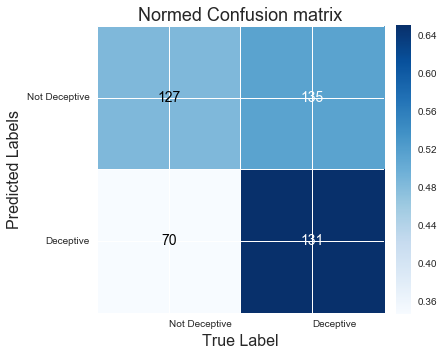

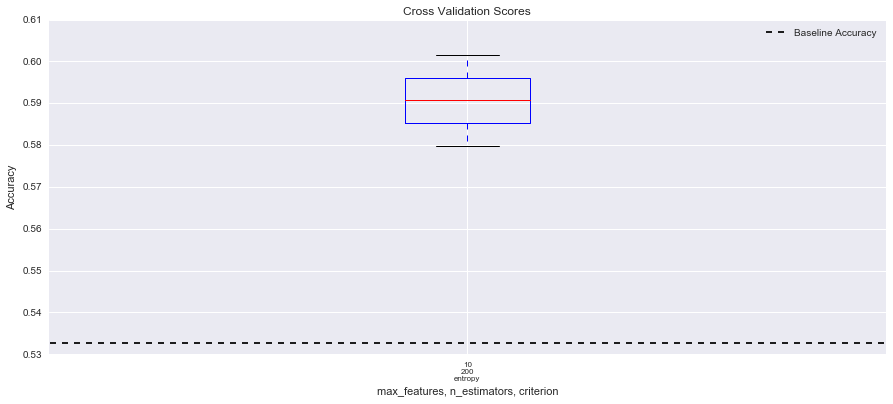

In [171]:
plot_confusion_matrix(rf_results['cm'])
plot_grid_scores(rf_results['grid_scores'])

In [218]:
imports = sorted(zip(list(np.array(feature_labels)[select_mask]), 
                     list(rf_results['clf'].feature_importances_.reshape(-1))), 
                 key=lambda x:x[1], reverse=True)
for i, (l, f) in enumerate(imports[:30]):
    print "%i :: %2.4f : %s" % (i, f,l)

0 :: 0.0470 : mfcc_sma[8]_maxPos
1 :: 0.0468 : mfcc_sma[12]_maxPos
2 :: 0.0459 : mfcc_sma_de[4]_maxPos
3 :: 0.0459 : mfcc_sma_de[9]_maxPos
4 :: 0.0443 : mfcc_sma[7]_minPos
5 :: 0.0439 : mfcc_sma[6]_minPos
6 :: 0.0439 : mfcc_sma_de[14]_maxPos
7 :: 0.0436 : pcm_Mag_harmonicity_sma_de_minPos
8 :: 0.0435 : audSpec_Rfilt_sma_de[22]_peakMeanRel
9 :: 0.0418 : pcm_Mag_spectralVariance_sma_de_peakMeanRel
10 :: 0.0414 : mfcc_sma_de[5]_peakMeanRel
11 :: 0.0412 : mfcc_sma_de[7]_peakMeanRel
12 :: 0.0412 : mfcc_sma_de[12]_peakMeanRel
13 :: 0.0410 : mfcc_sma_de[2]_peakMeanRel
14 :: 0.0409 : pcm_Mag_spectralSlope_sma_de_peakMeanRel
15 :: 0.0395 : pcm_Mag_spectralKurtosis_sma_de_peakMeanRel
16 :: 0.0392 : mfcc_sma_de[8]_peakMeanRel
17 :: 0.0383 : audSpec_Rfilt_sma_de[8]_peakMeanRel
18 :: 0.0381 : audSpec_Rfilt_sma_de[23]_peakMeanRel
19 :: 0.0374 : audSpec_Rfilt_sma_de[18]_peakMeanRel
20 :: 0.0292 : audSpec_Rfilt_sma_de[19]_minSegLen
21 :: 0.0281 : jitterLocal_sma_de_lpc4
22 :: 0.0276 : LIWC_tentat_func

## Clustering of per person covariates using stability selection analysis

In [57]:
train_pids = all_train.index.get_level_values(level=0).unique()
print len(train_pids)

64


In [84]:
# all_train[all_train.index.get_level_values('person') == 268]['label'].as_matrix()

In [88]:
rlrs = {}
for i, pid in enumerate(train_pids[:]):
    X = all_train[all_train.index.get_level_values('person') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('person') == pid]['label'].as_matrix()
    if len(np.unique(y)) < 2: 
        print "Bad PID: %i" % pid
        continue
    Cs = np.logspace(-4,5,10)
    rlr = RLR(C=Cs,
          scaling=.5,
          sample_fraction=.5,#.75, 
          n_resampling=200,
          selection_threshold=.5,#.75,
          normalize=False,
          random_state=random_seed,
          n_jobs=1)    
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
#     lsp = lasso_stability_path(X, y,
#                                scaling=.5,
#                                random_state=random_seed,
#                                n_resampling=5,#200,
#                                n_grid=5,#100,
#                                sample_fraction=0.5,#0.75,
#                                eps =.1,
#                                n_jobs=-1,
#                                verbose=True)
    try:
        rlr.fit(X, y)
    except ValueError:
        print "Subsampling Value Error for Bad PID: %i" % pid
        continue
    rlrs[pid] = rlr
print "DONE"

0 :: PID: 473, n: 76
1 :: PID: 472, n: 77
2 :: PID: 461, n: 25
Subsampling Value Error for Bad PID: 461
3 :: PID: 452, n: 64
4 :: PID: 453, n: 66
5 :: PID: 442, n: 28
6 :: PID: 443, n: 22
7 :: PID: 429, n: 90
8 :: PID: 414, n: 84
9 :: PID: 410, n: 100
10 :: PID: 409, n: 17
Subsampling Value Error for Bad PID: 409
11 :: PID: 406, n: 68
12 :: PID: 407, n: 55
13 :: PID: 398, n: 26
14 :: PID: 399, n: 23
15 :: PID: 386, n: 78
16 :: PID: 387, n: 52
17 :: PID: 382, n: 47
18 :: PID: 383, n: 20
19 :: PID: 378, n: 28
20 :: PID: 379, n: 21
Subsampling Value Error for Bad PID: 379
21 :: PID: 369, n: 94
22 :: PID: 368, n: 13
Subsampling Value Error for Bad PID: 368
23 :: PID: 360, n: 26
Subsampling Value Error for Bad PID: 360
24 :: PID: 352, n: 92
25 :: PID: 346, n: 28
26 :: PID: 347, n: 29
Subsampling Value Error for Bad PID: 347
27 :: PID: 344, n: 15
Subsampling Value Error for Bad PID: 344
28 :: PID: 345, n: 8
Subsampling Value Error for Bad PID: 345
29 :: PID: 340, n: 36
30 :: PID: 334, n: 14


## Do a per person cross validated lasso to get the best C for performance

In [164]:
from sklearn.linear_model import LogisticRegressionCV as LRCV
train_pids = all_train.index.get_level_values(level=0).unique()
print Cs

[  1.00000000e-04   1.00000000e-03   1.00000000e-02   1.00000000e-01
   1.00000000e+00   1.00000000e+01   1.00000000e+02   1.00000000e+03
   1.00000000e+04   1.00000000e+05]


In [168]:
lrs = {}
for i, pid in enumerate(train_pids):
    lrcv = LRCV(Cs=Cs,
                cv=5,
                penalty='l1', 
                n_jobs=1, 
                refit=False, 
                random_state=random_seed, 
                solver='liblinear')
    X = all_train[all_train.index.get_level_values('person') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('person') == pid]['label'].as_matrix()
    if len(np.unique(y)) < 2:
        print "Bad PID"
        continue
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
    try:
        lrcv.fit(X, y)
    except ValueError:
        print "Subsampling Value Error for Bad PID: %i" % pid
        continue
    lrs[pid] = lrcv

0 :: PID: 473, n: 76
1 :: PID: 472, n: 77
2 :: PID: 461, n: 25
3 :: PID: 452, n: 64
4 :: PID: 453, n: 66
5 :: PID: 442, n: 28
6 :: PID: 443, n: 22
7 :: PID: 429, n: 90
8 :: PID: 414, n: 84
9 :: PID: 410, n: 100
10 :: PID: 409, n: 17
11 :: PID: 406, n: 68
12 :: PID: 407, n: 55
13 :: PID: 398, n: 26
14 :: PID: 399, n: 23
15 :: PID: 386, n: 78
16 :: PID: 387, n: 52
17 :: PID: 382, n: 47
18 :: PID: 383, n: 20
19 :: PID: 378, n: 28
20 :: PID: 379, n: 21
21 :: PID: 369, n: 94
22 :: PID: 368, n: 13
23 :: PID: 360, n: 26
24 :: PID: 352, n: 92
25 :: PID: 346, n: 28
26 :: PID: 347, n: 29
27 :: PID: 344, n: 15
28 :: PID: 345, n: 8
Subsampling Value Error for Bad PID: 345
29 :: PID: 340, n: 36
30 :: PID: 334, n: 14


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


31 :: PID: 335, n: 16
32 :: PID: 330, n: 3
Subsampling Value Error for Bad PID: 330
33 :: PID: 331, n: 8
34 :: PID: 322, n: 8
Subsampling Value Error for Bad PID: 322
35 :: PID: 314, n: 25
Bad PID
37 :: PID: 307, n: 25
Subsampling Value Error for Bad PID: 307
38 :: PID: 302, n: 22
39 :: PID: 303, n: 47
40 :: PID: 300, n: 11
41 :: PID: 299, n: 35
Bad PID
43 :: PID: 277, n: 122
44 :: PID: 274, n: 88
45 :: PID: 272, n: 16
46 :: PID: 270, n: 18
47 :: PID: 271, n: 25
48 :: PID: 269, n: 26
Bad PID
Bad PID
51 :: PID: 260, n: 80
52 :: PID: 261, n: 28
53 :: PID: 254, n: 72
54 :: PID: 255, n: 15
55 :: PID: 252, n: 79
56 :: PID: 253, n: 30
57 :: PID: 245, n: 21
58 :: PID: 230, n: 11
59 :: PID: 231, n: 35


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


60 :: PID: 228, n: 19
Bad PID
62 :: PID: 229, n: 19
63 :: PID: 221, n: 29


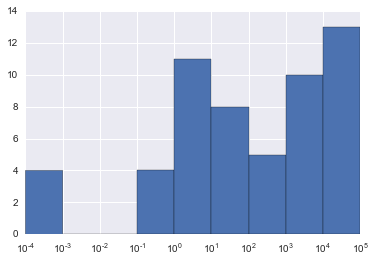

In [174]:
selected_cs = pd.Series([v.C_ for v in lrs.values() ])
fig, ax = plt.subplots()
selected_cs.hist(ax=ax, bins=Cs)
ax.set_xscale('log')
print

Looks like theyre quite variable, but centered around $C=1$, so we'll look at variable selection using the threshold at $C=1$

In [175]:
c_idx =list(Cs).index(1)
print c_idx

4


In [172]:
import warnings
warnings.filterwarnings('ignore')

In [173]:
from sklearn.linear_model import RandomizedLogisticRegression as RLR

rlrs = {}
for i, pid in enumerate(train_pids[:]):
    X = all_train[all_train.index.get_level_values('person') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('person') == pid]['label'].as_matrix()
    if len(np.unique(y)) < 2: 
        print "Bad PID: %i" % pid
        continue
    Cs = np.logspace(-4,5,10)
    rlr = RLR(C=Cs,
          scaling=.5,
          sample_fraction=.5,#.75, 
          n_resampling=200,
          selection_threshold=.5,#.75,
          normalize=False,
          random_state=random_seed,
          n_jobs=1)    
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
#     lsp = lasso_stability_path(X, y,
#                                scaling=.5,
#                                random_state=random_seed,
#                                n_resampling=5,#200,
#                                n_grid=5,#100,
#                                sample_fraction=0.5,#0.75,
#                                eps =.1,
#                                n_jobs=-1,
#                                verbose=True)
    try:
        rlr.fit(X, y)
    except ValueError:
        print "Subsampling Value Error for Bad PID: %i" % pid
        continue
    rlrs[pid] = rlr
print "DONE"

0 :: PID: 473, n: 76
1 :: PID: 472, n: 77
2 :: PID: 461, n: 25
3 :: PID: 452, n: 64
4 :: PID: 453, n: 66
5 :: PID: 442, n: 28
6 :: PID: 443, n: 22
Subsampling Value Error for Bad PID: 443
7 :: PID: 429, n: 90
8 :: PID: 414, n: 84
9 :: PID: 410, n: 100
10 :: PID: 409, n: 17
11 :: PID: 406, n: 68
12 :: PID: 407, n: 55
13 :: PID: 398, n: 26
14 :: PID: 399, n: 23
15 :: PID: 386, n: 78
16 :: PID: 387, n: 52
17 :: PID: 382, n: 47
18 :: PID: 383, n: 20
19 :: PID: 378, n: 28
20 :: PID: 379, n: 21
21 :: PID: 369, n: 94
22 :: PID: 368, n: 13
Subsampling Value Error for Bad PID: 368
23 :: PID: 360, n: 26
Subsampling Value Error for Bad PID: 360
24 :: PID: 352, n: 92
25 :: PID: 346, n: 28
26 :: PID: 347, n: 29
27 :: PID: 344, n: 15
Subsampling Value Error for Bad PID: 344
28 :: PID: 345, n: 8
Subsampling Value Error for Bad PID: 345
29 :: PID: 340, n: 36
30 :: PID: 334, n: 14
Subsampling Value Error for Bad PID: 334
31 :: PID: 335, n: 16
Subsampling Value Error for Bad PID: 335
32 :: PID: 330, n: 

## Visualize the stability selections at $C=1$

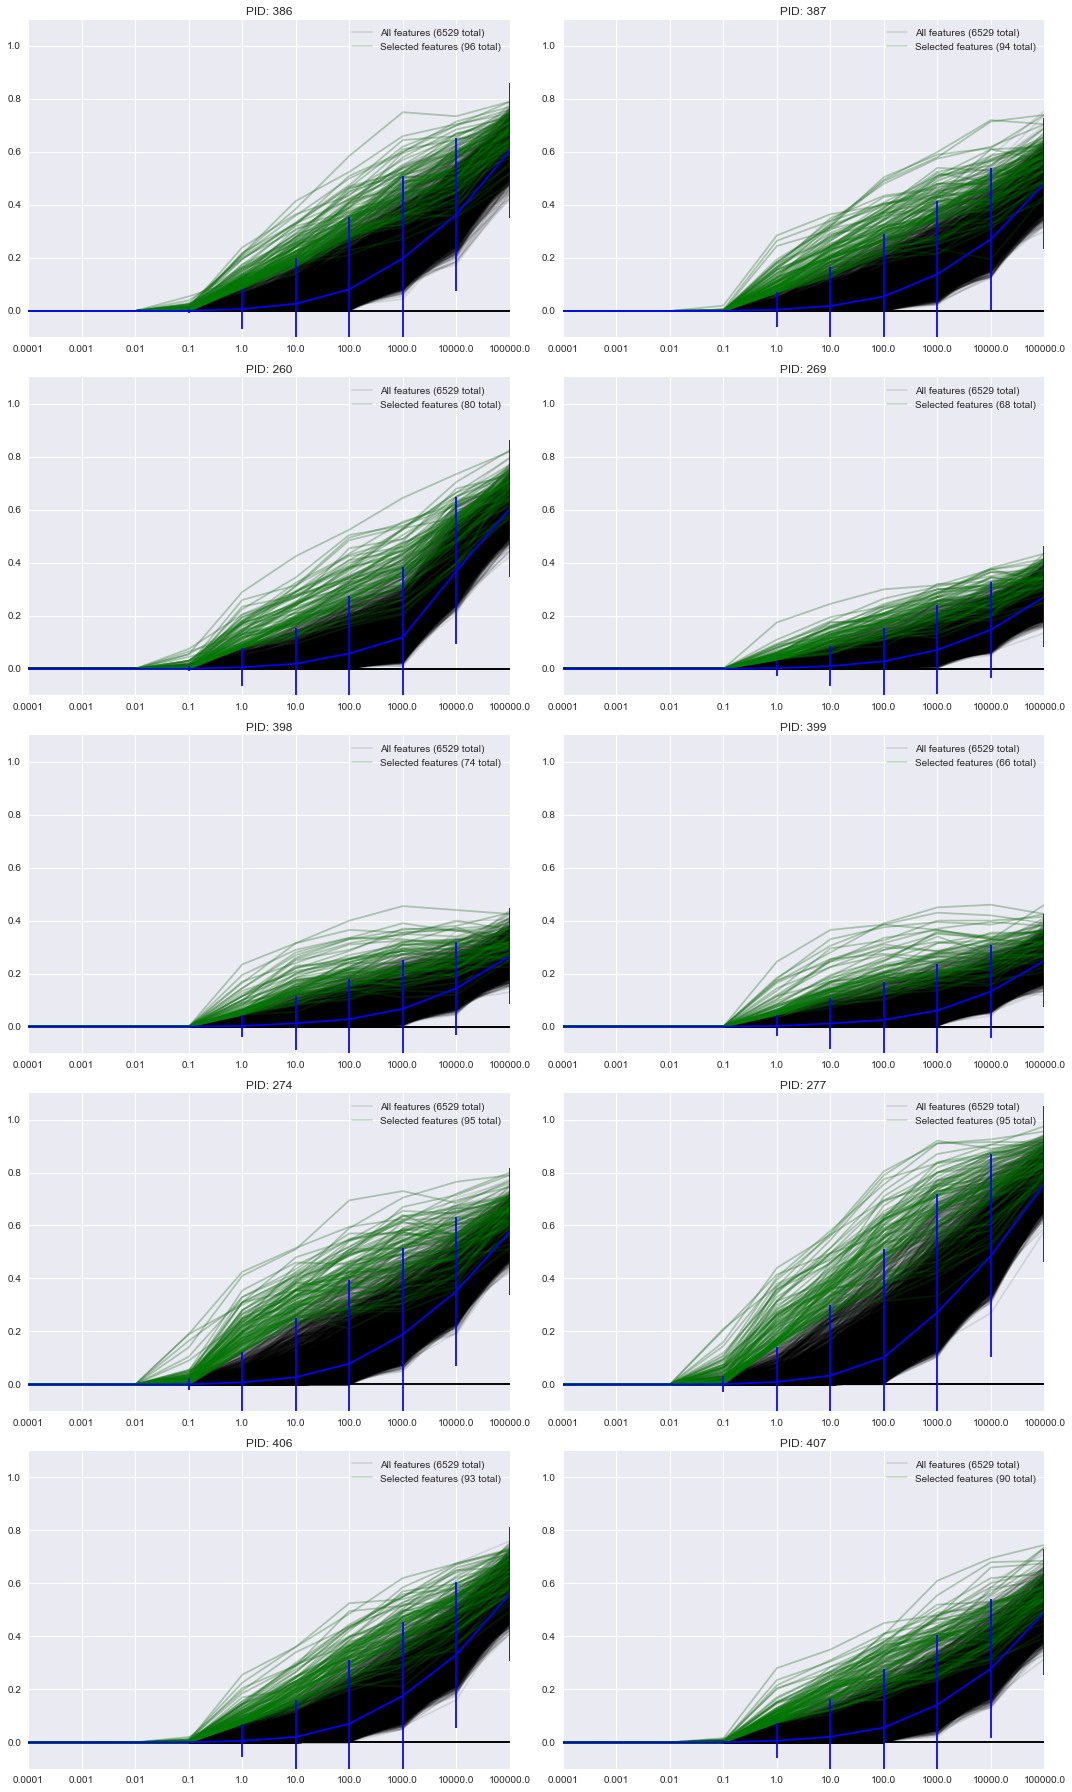

In [176]:
num = 10#len(rlrs)
nrows = num//2 if num % 2 == 0 else num//2+1
fig, axes = plt.subplots(nrows, 2, sharey=False, sharex=False, figsize=(15, nrows*5))
feature_indicators = {}
for i, (pid, rlr) in enumerate(rlrs.items()[:num]):
    ax = axes[i//2, i%2]
    scores = rlr.all_scores_
    avg = np.mean(scores.T, axis=1)
    std = np.std(scores.T, axis=1)

    # get the scores that are greater than 3 stddevs above average in at least one experiment
    num_std = 4
    thresh = avg + num_std*std
#     select_mask = np.any(scores[:, c_dx] > thresh[:,c_idx], axis=1) # all
    select_mask = scores[:, c_idx] > thresh[c_idx] # only at one c
    above = scores[select_mask]
    # print rlr.all_scores_.T.shape, above.shape

    ax.grid(zorder=0)
    s = ax.plot(scores.T, 'k', alpha=.1, zorder=1, label=('All features (%i total)'%scores.shape[0]))
    a = ax.plot(above.T, 'g', alpha=.2, zorder=2, label=('Selected features (%i total)'%above.shape[0]))
    ax.set_xticks(range(len(Cs)))
    ax.set_xticklabels(Cs)
    e = ax.errorbar(range(len(Cs)), avg, yerr=num_std*std, color='b', ecolor='b', zorder=3, label='Mean selection w/ 3 std')
#     ax.set_title("Stability Paths of all features")
#     ax.set_xlabel('$C$')
#     ax.set_ylabel('Selection Probability')
    ax.legend(handles=[s[0], a[0], e[0]])
    ax.set_title('PID: %i' % pid)
    ax.set_ylim(0.-.1,1.1)
#     ax.axvline(c_idx, ymin=-.1, ymax=1.1)
    
    # keep the selection vector
#     feature_indicators[pid] = select_mask.astype(np.int).reshape(-1,1)
fig.tight_layout()

In [57]:
scores =rlrs.values()[0].all_scores_
scores.shape, c_idx

((6529, 10), 6)

(6529,)


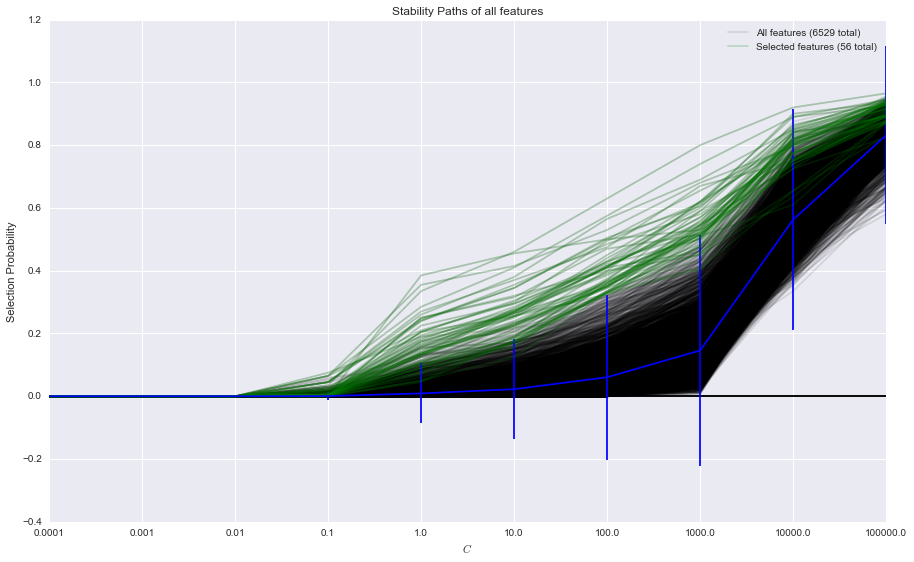

In [142]:
scores =rlrs.values()[0].all_scores_
avg = np.mean(scores.T, axis=1)
std = np.std(scores.T, axis=1)

# get the scores that are greater than 3 stddevs above average in at least one experiment
num_std = 4
thresh = avg + num_std*std
select_mask = scores[:, c_idx] > thresh[c_idx]
print select_mask.shape
above = scores[select_mask]
# print rlr.all_scores_.T.shape, above.shape

fig, ax = plt.subplots(1,1, figsize=(15,9))
ax.grid(zorder=0)
s = ax.plot(scores.T, 'k', alpha=.1, zorder=1, label=('All features (%i total)'%scores.shape[0]))
a = ax.plot(above.T, 'g', alpha=.2, label=('Selected features (%i total)'%above.shape[0]))
ax.set_xticks(range(len(Cs)))
ax.set_xticklabels(Cs)
e = ax.errorbar(range(len(Cs)), avg, yerr=num_std*std, color='b', ecolor='b', zorder=2, label='Mean selection w/ 3 std')
ax.set_title("Stability Paths of all features")
ax.set_xlabel('$C$')
ax.set_ylabel('Selection Probability')
ax.legend(handles=[s[0], a[0], e[0]])

In [233]:
thresh = avg + 3*std
s = rlr.all_scores_
s[np.any(s > thresh, axis=1)].shape

(196, 10)

In [243]:
vec = np.any(scores > thresh, axis=1).astype(np.int)

True


In [177]:
from copy import deepcopy
rlrs_copy = deepcopy(rlrs)

In [178]:
from copy import copy
rlrs = deepcopy(rlrs_copy)

In [179]:
def select_stable(num_std=3):
    feature_indicators = {}
    rlrs = deepcopy(rlrs_copy)
    num = len(rlrs)
    for i, (pid, rlr) in enumerate(rlrs.items()[:num]):
        scores = copy(rlr.all_scores_)
        avg = np.mean(scores.T, axis=1)
        std = np.std(scores.T, axis=1)

        # get the scores that are greater than 3 stddevs above average in at least one experiment
#         num_std = 
        thresh = avg + num_std*std
    #     select_mask = np.any(scores > thresh, axis=1) #all
        select_mask = scores[:, c_idx] > thresh[c_idx] # best C
        above = scores[select_mask]
        scores[~select_mask] = 0
        scores[select_mask] = 1 #above[c_idx] # 1
        feature_indicators[pid] = scores.reshape(-1,1)
    pids = feature_indicators.keys()
    var_ind = np.concatenate(feature_indicators.values(), axis=1).T
    return var_ind, pids

## Any variable selection clusterings?

In [180]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [96]:
# var_ind = select_stable(2)[:,:]
# U, D, V = np.linalg.svd(var_ind)

In [97]:
pids = feature_indicators.keys()

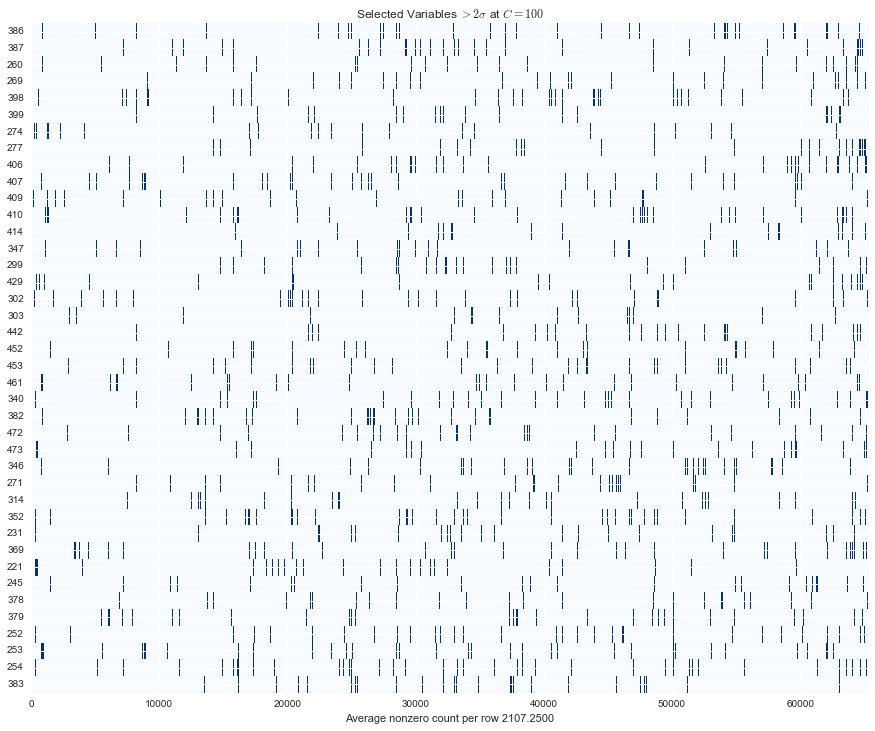

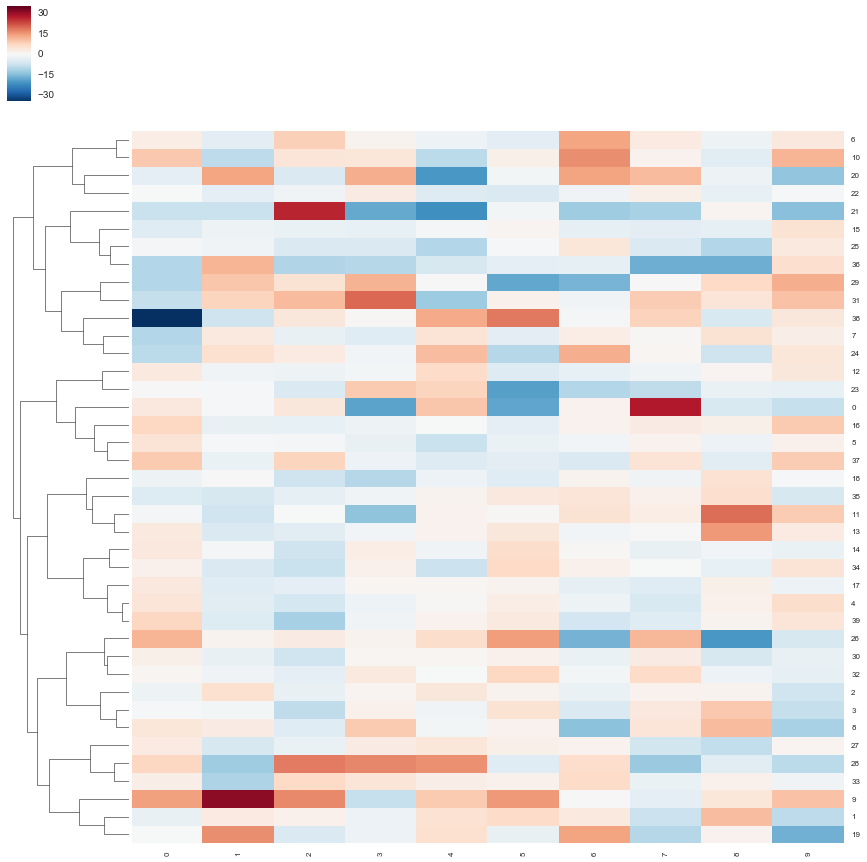

In [181]:
var_ind, pids = select_stable(2)

fig, ax = plt.subplots(1,1, figsize=(15,12))
ax.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
ax.set_yticks(range(len(pids)))
ax.set_yticklabels(pids)
plt.title("Selected Variables $> 2\sigma$ at $C=100$")
avg_row_count = np.mean((var_ind != 0).sum(1))
ax.set_xlabel('Average nonzero count per row %2.4f' % avg_row_count)
print ''

pca = PCA(n_components=10)
medd = pca.fit_transform(var_ind)

# fig, ax = plt.subplots(1,1, figsize=(15,18))
# ax.set_title('1000 D PCA embeddings')
# im = ax.imshow(medd, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.colorbar(im, fraction=0.046, pad=0.04)
# print ''

g = sb.clustermap(medd, method='complete', metric='cosine', 
                  figsize=(15,15), row_cluster=True, col_cluster=False)
heatmap = g.ax_heatmap
labels = heatmap.get_yticklabels()
heatmap.set_yticklabels(labels, rotation=0, fontsize=8)
labels = heatmap.get_xticklabels()
heatmap.set_xticklabels(labels, rotation=90, fontsize=8)
print

pca = PCA(n_components=2)
lowd = pca.fit_transform(var_ind)

fig, ax = plt.subplots(figsize=(9,9))
ax.set_title('2D PCA embeddings')
scatter = ax.scatter(lowd[:,0], lowd[:,1])
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# lowd = tsne.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D TSNE embeddings')

# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()




[ 0.03422011  0.03325812  0.03234461  0.03189089  0.03134836  0.03059336
  0.03036931  0.03007637  0.02935385  0.02929249  0.02837467  0.02805054
  0.02767427  0.02741133  0.02692138  0.02663138  0.02626271  0.02603505
  0.02584236  0.02501172]



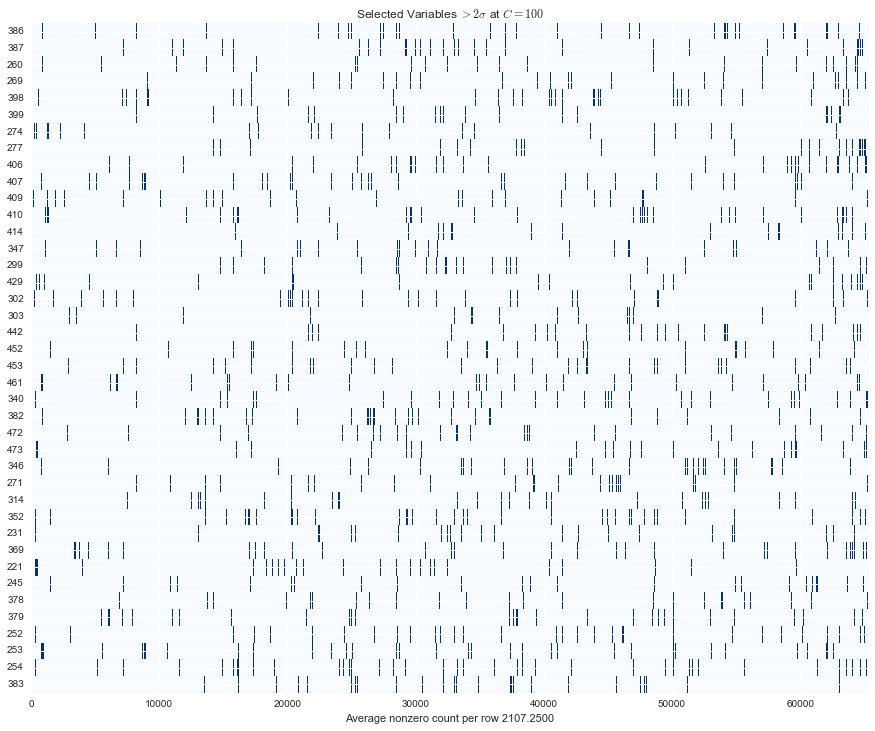

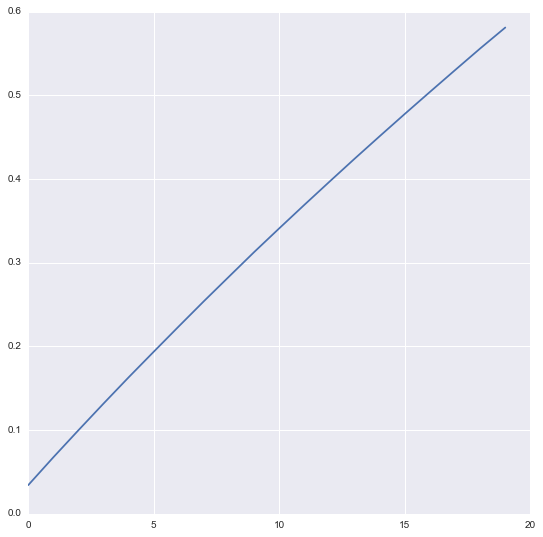

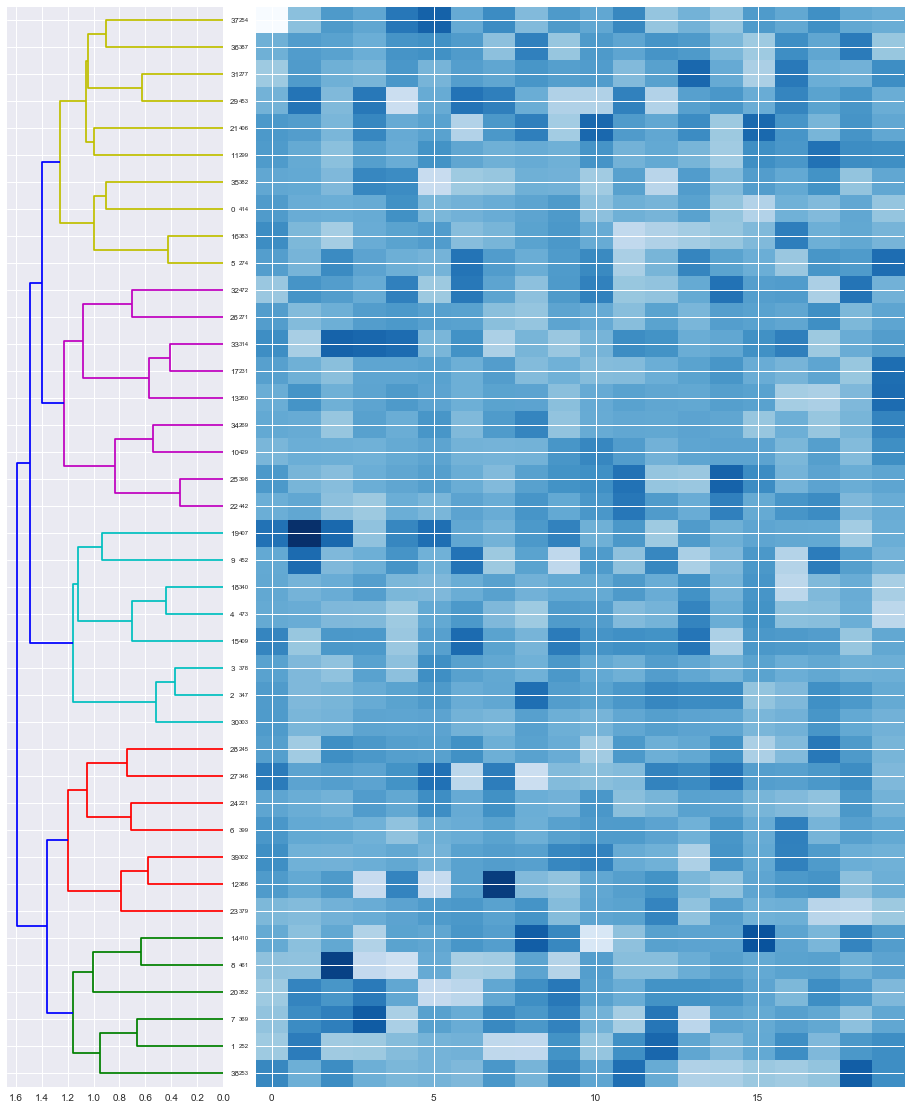

In [339]:
var_ind, pids = select_stable(2)

fig, ax = plt.subplots(1,1, figsize=(15,12))
ax.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
ax.set_yticks(range(len(pids)))
ax.set_yticklabels(pids)
plt.title("Selected Variables $> 2\sigma$ at $C=100$")
avg_row_count = np.mean((var_ind != 0).sum(1))
ax.set_xlabel('Average nonzero count per row %2.4f' % avg_row_count)
print ''

pca = PCA(n_components=20)
medd = pca.fit_transform(var_ind)

pca_var = pca.explained_variance_ratio_
# PCA variance plot
fig, ax = plt.subplots(1,1, figsize=(9,9))
plt.plot(range(len(pca_var)), np.cumsum(pca_var))
print pca_var
# fig, ax = plt.subplots(1,1, figsize=(15,18))
# ax.set_title('1000 D PCA embeddings')
# im = ax.imshow(medd, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.colorbar(im, fraction=0.046, pad=0.04)
# print ''

#dendrogram ax
# selections = deepcopy(var_ind)
fig = plt.figure(figsize=(15,15))
axd = fig.add_axes([0.09,0.1,0.2,1])
# var_ind, pids = select_stable(4)
links = linkage(medd, method='complete', metric='cosine')
dend = dendrogram(links, orientation='left', color_threshold=0.8*max(links[:,2]))
# axd.set_xticks([])
# axd.set_yticks([])

# matrix ax
axm = fig.add_axes([0.32,0.1,0.6,1])
medd = medd[dend['leaves'],:]
axm.imshow(medd, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
axm.set_yticks(range(len(pids)))
pids = np.array(pids)[dend['leaves']]
axm.set_yticklabels(pids, fontsize=6)
# axm.set_yticks(pids)
print

# pca = PCA(n_components=2)
# lowd = pca.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D PCA embeddings')
# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# lowd = tsne.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D TSNE embeddings')

# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()



40 40
[4, 0, 2, 2, 2, 4, 1, 0, 0, 2, 3, 4, 1, 3, 0, 2, 4, 3, 2, 2, 0, 4, 3, 1, 1, 3, 3, 1, 1, 4, 2, 4, 3, 3, 3, 4, 4, 4, 0, 1]


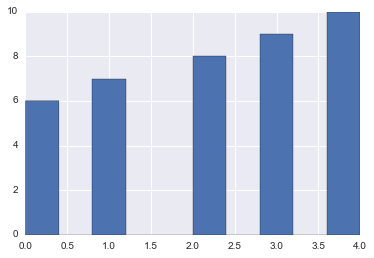

In [330]:
cluster_assignments = fcluster(links, .8*max(links[:,2]), 'distance')
# set the clusters to 0 indexing
cluster_assignments = [ c-1 for c in list(cluster_assignments)]
print len(cluster_assignments), len(pids)
print cluster_assignments
clusters = pd.Series(cluster_assignments)
clusters.hist()

## Train 5 weak learners based on stability selection clusterings

In [257]:
print Cs

[  1.00000000e-04   1.00000000e-03   1.00000000e-02   1.00000000e-01
   1.00000000e+00   1.00000000e+01   1.00000000e+02   1.00000000e+03
   1.00000000e+04   1.00000000e+05]


In [ ]:
from sklearn

In [334]:
# clfs = [ LRCV(Cs=Cs, cv=3, penalty='l2') for i in range(len(set(cluster_assignments)))]
clfs = [ RF(n_estimators=20, criterion='entropy', max_features='log2', n_jobs=-1) 
        for i in range(len(set(cluster_assignments)))]
for i in range(len(set(cluster_assignments))):
    print i
    cluster_pids = [pid for (pid, clust) in zip(pids, cluster_assignments) if clust==i]
    X = all_train[all_train.index.get_level_values('person').isin(cluster_pids)].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('person').isin(cluster_pids)]['label'].as_matrix()
    clfs[i].fit(X,y)
print "DONE"

0
1
2
3
4
DONE


In [320]:
from scipy.stats import mode

In [321]:
lr_predict = lambda x: 1 if x >=.5 else 0
certainty = lambda x: abs(x - .5)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

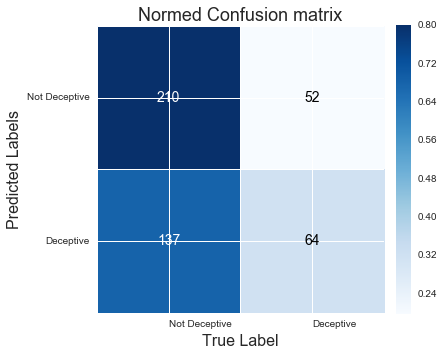

In [338]:
preds = []
for i in range(len(test_x)):
    print i,
    pred = [clf.predict(test_x[i,:])[0] for clf in clfs]
#     certainties = [certainty(p) for p in pred]
#     print i, pred, lr_predict(pred[certainties.index(max(certainties))])
#     preds.append(lr_predict(np.mean(pred)))
    preds.append(mode(pred)[0])
#     preds.append(lr_predict(pred[certainties.index(max(certainties))]))
# print preds
acc = accuracy_score(test_y, preds)
p = precision_score(test_y, preds)
r = recall_score(test_y, preds)
f1 = f1_score(test_y, preds)
print "Test Accuracy: %1.4f, Test F1: %1.4f (P:%0.2f R:%0.2f)" % (acc, f1, p, r)
confusion_matrix = cm(test_y, preds)
plot_confusion_matrix(confusion_matrix)

In [337]:
test_x.shape

(463, 6529)

## Non Ensembled Ridge:

In [297]:
lr = LR(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid = dict(
                  penalty=['l2'], 
#                   dual=False, 
#                   tol=0.0001, 
                  C=Cs, 
#                   fit_intercept=True, 
#                   intercept_scaling=1, 
#                   class_weight=None, 
#                   random_state=random_seed, 
#                   solver='liblinear', 
#                   max_iter=100, 
#                   multi_class='ovr', 
#                   verbose=0, 
#                   warm_start=False, 
#                   n_jobs=1
                 )
lr_all_results = experiment(lr, param_grid, cv=5)

Searching Grid...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
plot_confusion_matrix(lr_all_results['cm'])

In [221]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

In [66]:
def sparse_to_prox(sparse, metric='cosine'):
    n = sparse.shape[0]
    prox = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            dist  = pdist(sparse[i])

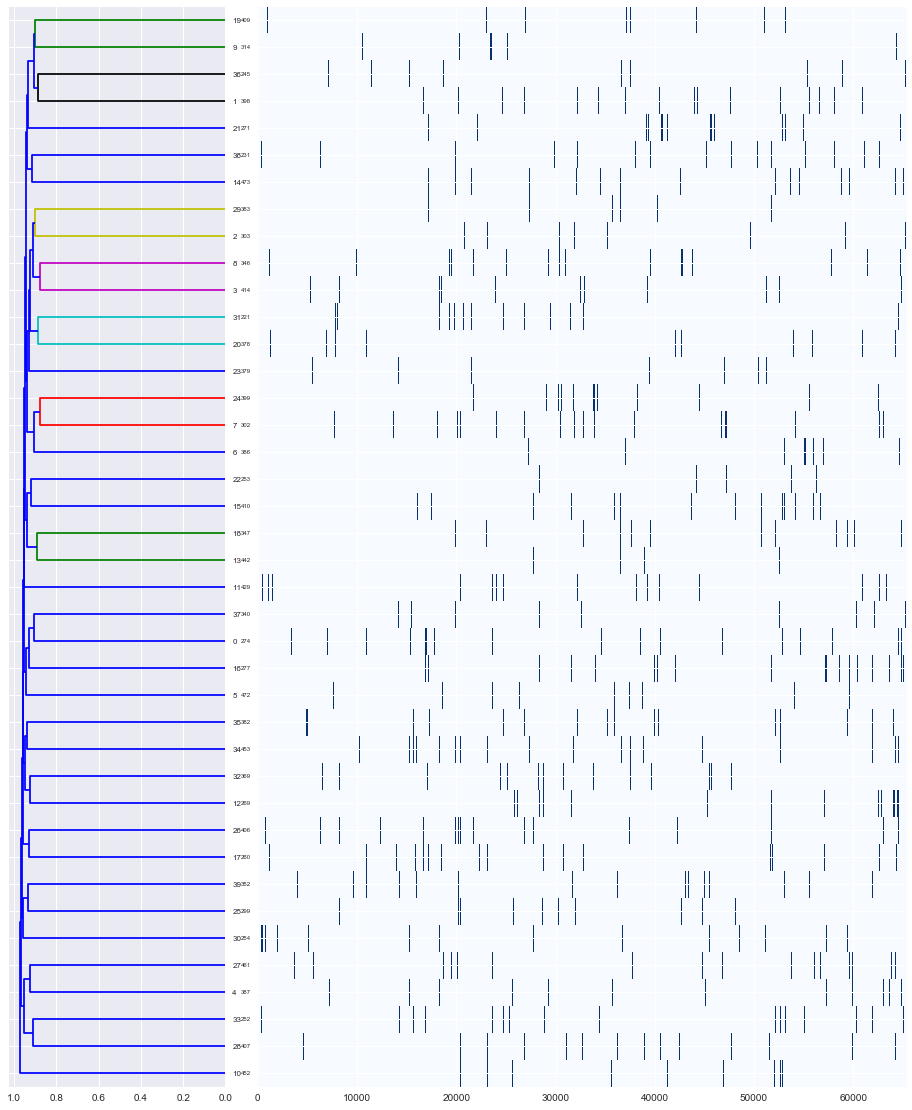

In [185]:
var_ind, pids = select_stable(3)
# dendrogram ax
fig = plt.figure(figsize=(15,15))
axd = fig.add_axes([0.09,0.1,0.2,1])
# var_ind, pids = select_stable(4)
links = linkage(var_ind, method='average', metric='cosine')
dend = dendrogram(links, color_threshold=.9, orientation='left')
# axd.set_xticks([])
# axd.set_yticks([])

# matrix ax
axm = fig.add_axes([0.32,0.1,0.6,1])
var_ind = var_ind[dend['leaves'],:]
axm.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
axm.set_yticks(range(len(pids)))
pids = np.array(pids)[dend['leaves']]
axm.set_yticklabels(pids, fontsize=6)
# axm.set_yticks(pids)
print

In [ ]:
var_ind, pids = select_stable(3)

# do pca first

# dendrogram ax
fig = plt.figure(figsize=(15,15))
axd = fig.add_axes([0.09,0.1,0.2,1])
# var_ind, pids = select_stable(4)
links = linkage(var_ind, method='complete', metric='jaccard')
dend = dendrogram(links, color_threshold=.9, orientation='left')
# axd.set_xticks([])
# axd.set_yticks([])

# matrix ax
axm = fig.add_axes([0.32,0.1,0.6,1])
var_ind = var_ind[dend['leaves'],:]
axm.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
axm.set_yticks(range(len(pids)))
pids = np.array(pids)[dend['leaves']]
axm.set_yticklabels(pids, fontsize=6)
# axm.set_yticks(pids)
print

IndexError: positional indexers are out-of-bounds

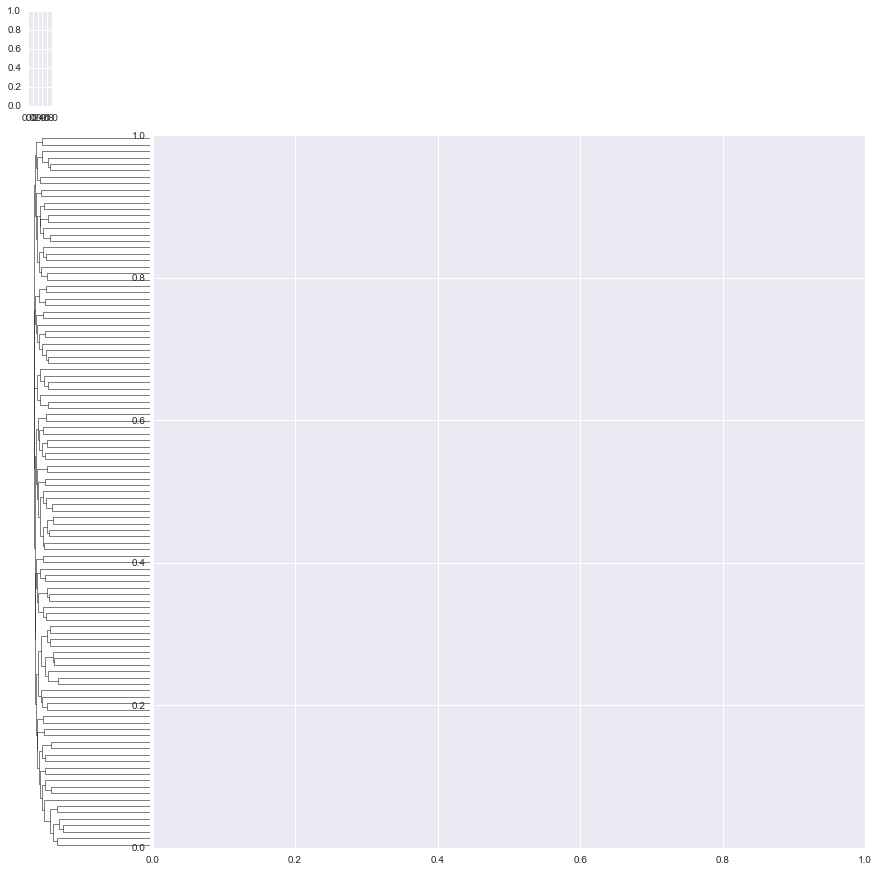

In [191]:
var_ind, pids = select_stable(3)

# fig, ax = plt.subplots(1,1, figsize=(15,12))
# ax.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.title("Selected Variables $> 2\sigma$ at $C=100$")
# avg_row_count = np.mean((var_ind != 0).sum(1))
# ax.set_xlabel('Average nonzero count per row %2.4f' % avg_row_count)
# print ''

pca = PCA(n_components=10)
medd = pca.fit_transform(var_ind)

# fig, ax = plt.subplots(1,1, figsize=(15,18))
# ax.set_title('1000 D PCA embeddings')
# im = ax.imshow(medd, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.colorbar(im, fraction=0.046, pad=0.04)
# print ''

g = sb.clustermap(medd, method='complete', metric='cosine', 
                  row_cluster=True, col_cluster=False,
                  row_linkage=links, figsize=(15,15))
heatmap = g.ax_heatmap
labels = heatmap.get_yticklabels()
heatmap.set_yticklabels(labels, rotation=0, fontsize=8)
labels = heatmap.get_xticklabels()
heatmap.set_xticklabels(labels, rotation=90, fontsize=8)
print

# pca = PCA(n_components=2)
# lowd = pca.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D PCA embeddings')
# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# lowd = tsne.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D TSNE embeddings')

# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()



## Do a per person Ridge Regression

In [61]:
# from sklearn.linear_model import Log
from sklearn.linear_model import LogisticRegressionCV as LRCV
lr2s = {}
for i, pid in enumerate(train_pids[:]):
    X = all_train[all_train.index.get_level_values('person') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('person') == pid]['label'].as_matrix()
    if len(np.unique(y)) < 2: 
        print "Bad PID: %i" % pid
        continue
    Cs = np.logspace(-4,5,10)
    lr2 = LRCV(Cs=Cs, cv=10, penalty='l2', refit=False)   
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
#     lsp = lasso_stability_path(X, y,
#                                scaling=.5,
#                                random_state=random_seed,
#                                n_resampling=5,#200,
#                                n_grid=5,#100,
#                                sample_fraction=0.5,#0.75,
#                                eps =.1,
#                                n_jobs=-1,
#                                verbose=True)
    try:
        lr2.fit(X, y)
    except ValueError:
        print "Subsampling Value Error for Bad PID: %i" % pid
        continue
    lr2s[pid] = lr2
print "DONE"

0 :: PID: 473, n: 76
1 :: PID: 472, n: 77
2 :: PID: 461, n: 25
3 :: PID: 452, n: 64
4 :: PID: 453, n: 66
5 :: PID: 442, n: 28
6 :: PID: 443, n: 22
7 :: PID: 429, n: 90
8 :: PID: 414, n: 84
9 :: PID: 410, n: 100
10 :: PID: 409, n: 17


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Subsampling Value Error for Bad PID: 409
11 :: PID: 406, n: 68
12 :: PID: 407, n: 55
13 :: PID: 398, n: 26
14 :: PID: 399, n: 23
15 :: PID: 386, n: 78
16 :: PID: 387, n: 52
17 :: PID: 382, n: 47
18 :: PID: 383, n: 20


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


19 :: PID: 378, n: 28
20 :: PID: 379, n: 21
21 :: PID: 369, n: 94
22 :: PID: 368, n: 13


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Subsampling Value Error for Bad PID: 368
23 :: PID: 360, n: 26


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


24 :: PID: 352, n: 92
25 :: PID: 346, n: 28
26 :: PID: 347, n: 29
27 :: PID: 344, n: 15
28 :: PID: 345, n: 8
Subsampling Value Error for Bad PID: 345
29 :: PID: 340, n: 36
30 :: PID: 334, n: 14


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


31 :: PID: 335, n: 16


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Subsampling Value Error for Bad PID: 335
32 :: PID: 330, n: 3
Subsampling Value Error for Bad PID: 330
33 :: PID: 331, n: 8
Subsampling Value Error for Bad PID: 331
34 :: PID: 322, n: 8
Subsampling Value Error for Bad PID: 322
35 :: PID: 314, n: 25
Bad PID: 315
37 :: PID: 307, n: 25


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


38 :: PID: 302, n: 22
39 :: PID: 303, n: 47
40 :: PID: 300, n: 11
Subsampling Value Error for Bad PID: 300
41 :: PID: 299, n: 35
Bad PID: 289
43 :: PID: 277, n: 122
44 :: PID: 274, n: 88
45 :: PID: 272, n: 16
Subsampling Value Error for Bad PID: 272
46 :: PID: 270, n: 18
Subsampling Value Error for Bad PID: 270
47 :: PID: 271, n: 25
48 :: PID: 269, n: 26
Bad PID: 265
Bad PID: 263
51 :: PID: 260, n: 80
52 :: PID: 261, n: 28
53 :: PID: 254, n: 72
54 :: PID: 255, n: 15
Subsampling Value Error for Bad PID: 255
55 :: PID: 252, n: 79
56 :: PID: 253, n: 30
57 :: PID: 245, n: 21
58 :: PID: 230, n: 11


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Subsampling Value Error for Bad PID: 230
59 :: PID: 231, n: 35
60 :: PID: 228, n: 19
Bad PID: 226
62 :: PID: 229, n: 19
63 :: PID: 221, n: 29
DONE


In [62]:
pids = lr2s.keys()
beta_mat = np.concatenate([v.coef_.reshape(-1,1) for v in lr2s.values()], axis=1).T
print beta_mat.shape
print len(pids)

(47, 6529)
47


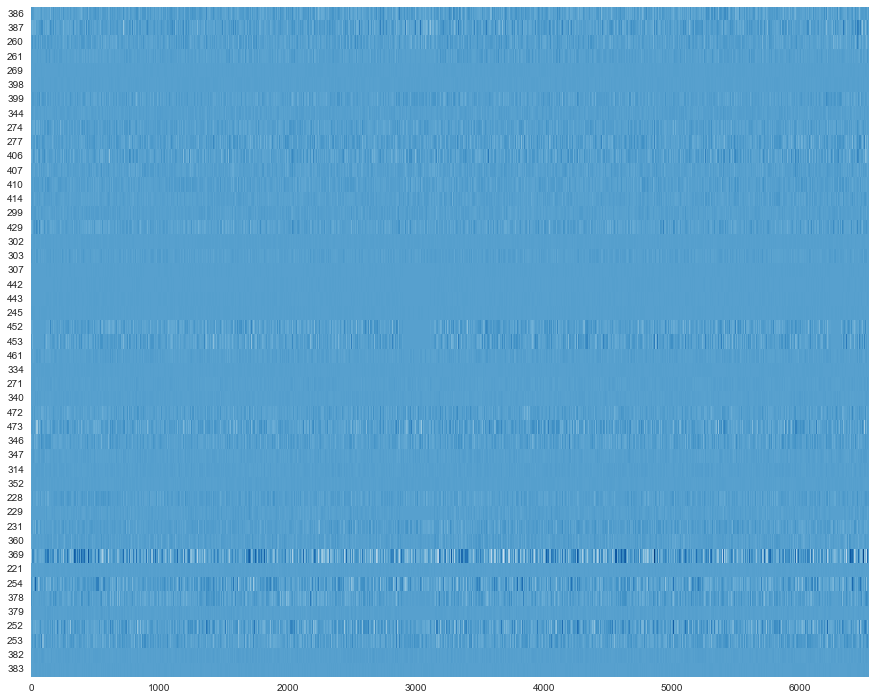

In [63]:
fig, ax = plt.subplots(1,1, figsize=(15,12))
ax.imshow(beta_mat, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
ax.set_yticks(range(len(pids)))
ax.set_yticklabels(pids)
ax.grid(False)
# plt.title("Selected Variables $> 2\sigma$ at $C=100$")
# avg_row_count = /np.mean((var_ind != 0).sum(1))
# ax.set_xlabel('Average nonzero count per row %2.4f' % avg_row_count)
print ''

In [140]:
from copy import copy
cluster_x = copy(train_x)

IndexError: index 54 is out of bounds for axis 1 with size 47

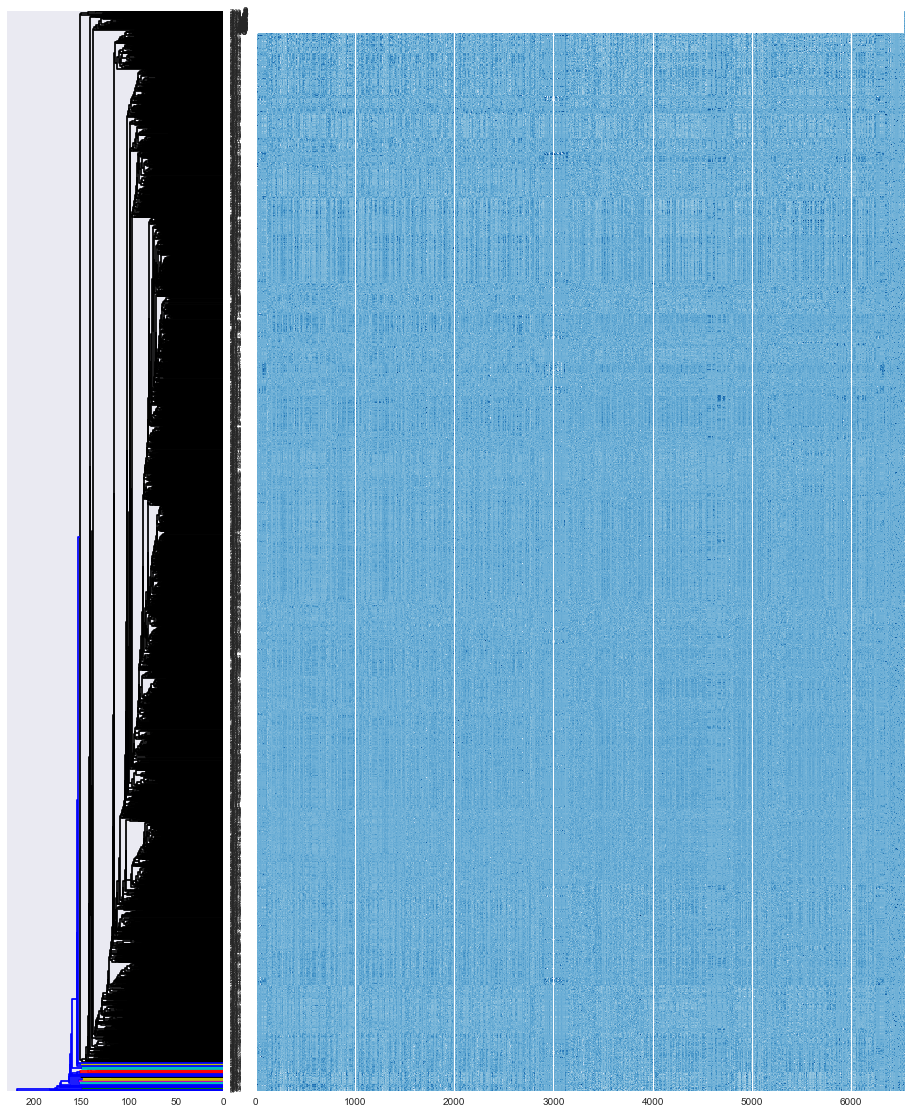

In [141]:
# dendrogram ax
fig = plt.figure(figsize=(15,15))
axd = fig.add_axes([0.09,0.1,0.2,1])
# var_ind, pids = select_stable(4)
links = linkage(cluster_x, method='average', metric='euclidean')
dend = dendrogram(links, orientation='left')
axd.grid(False)
# axd.set_xticks([])
# axd.set_yticks([])

# matrix ax
axm = fig.add_axes([0.32,0.1,0.6,1])
cluster_x = cluster_x[dend['leaves'],:]
axm.imshow(cluster_x, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
axm.set_yticks(range(len(pids)))
pids = np.array(pids)[dend['leaves']]
axm.set_yticklabels(pids, fontsize=6)
axm.grid(False)
# axm.set_yticks(pids)
print

In [142]:
truths = copy(train_x[train_y==0])
lies = copy(train_x[train_y==1])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2365
[t-SNE] Computed conditional probabilities for sample 2000 / 2365
[t-SNE] Computed conditional probabilities for sample 2365 / 2365
[t-SNE] Mean sigma: 17.254486
[t-SNE] Error after 100 iterations with early exaggeration: 0.820679
[t-SNE] Error after 275 iterations: 0.792283


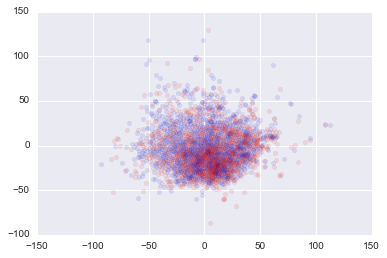

In [163]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2, perplexity=60, init='pca', verbose=1)
low_d = tsne.fit_transform(np.vstack([truths, lies]))
low_true = low_d[:truths.shape[0],:]
low_lies = low_d[truths.shape[0]:,:]
# pca = PCA(n_components=2)
# low_true = pca.fit_transform(truths)

plt.scatter(low_true[:,0], low_true[:,1], c='b', alpha=.1)
plt.scatter(low_lies[:,0], low_lies[:,1], c='r', alpha=.1)

In [ ]:
### CUSTOM MPLD3 CLASS FOR VISUALIZING STABILITY PATHS ###
class HighlightLines(mpld3.plugins.PluginBase):
    """A plugin to highlight lines on hover"""

    JAVASCRIPT = """
    mpld3.register_plugin("linehighlight", LineHighlightPlugin);
    LineHighlightPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LineHighlightPlugin.prototype.constructor = LineHighlightPlugin;
    LineHighlightPlugin.prototype.requiredProps = ["line_ids"];
    LineHighlightPlugin.prototype.defaultProps = {alpha_bg:0.1, alpha_fg:1.0, 
                                                  bg_color:"#000000", fg_color:"#00FF00"};
    function LineHighlightPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LineHighlightPlugin.prototype.draw = function(){
      for(var i=0; i<this.props.line_ids.length; i++){
         var obj = mpld3.get_element(this.props.line_ids[i], this.fig),
             alpha_fg = this.props.alpha_fg;
             alpha_bg = this.props.alpha_bg;
             bg_color = this.props.bg_color;
             fg_color = this.props.fg_color;
         obj.elements()
             .on("mouseover", function(d, i){
                            d3.select(this).transition().duration(50)
                              .style("stroke-opacity", alpha_fg)
                              .style("stroke-color", fg_color); })
             .on("mouseout", function(d, i){
                            d3.select(this).transition().duration(200)
                              .style("stroke-opacity", alpha_bg)
                              .style("stroke-color", bg_color); });
      }
    };
    """

    def __init__(self, lines):
        self.lines = lines
        self.dict_ = {"type": "linehighlight",
                      "line_ids": [mpld3.utils.get_id(line) for line in lines],
                      "alpha_bg": lines[0].get_alpha(),
                      "alpha_fg": 1.0,
                      "bg_color": lines[0].get_color(),
                      "fg_color":"#00FF00"}

## Last ditch MLP effort

In [110]:
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.regularizers import l1, l2
from keras.optimizers import SGD
from keras.utils import np_utils # convert classes to dense for compatibility

In [28]:
import random

In [133]:
inputs = Input(shape=(6542,))
x = Dense(2000, activation="relu")(inputs)
x = Dense(500, activation='relu')(inputs)
predictions = Dense(2, activation='softmax')(x)
model = Model(input=inputs, output = predictions)


# model.add(Dense(input_dim=6542, output_dim=500))
# model.add(Activation("tanh"))
# model.add(Dense(output_dim=2))
# model.add(Activation("softmax"))

In [134]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',#SGD(lr=0.01, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])

In [135]:
train_x.shape

(2365, 6542)

In [136]:
from sklearn.cross_validation import train_test_split
# tr_x, dev_x, tr_y, dev_y = train_test_split(train_x, train_y, test_size=500, random_state=random_seed)
tr_x = train_x[:,:]
dev_x = test_x[:,:]
tr_y = train_y[:]
dev_y = test_y[:]
tr_y = np_utils.to_categorical(tr_y)
dev_y = np_utils.to_categorical(dev_y)
te_x = test_x[:,:]
te_y = test_y[:]
# te_y = np_utils.to_categorical(test_y[:])
dev_x.shape, dev_y.shape, tr_x.shape, tr_y.shape, te_x.shape, te_y.shape

((463, 6542), (463, 2), (2365, 6542), (2365, 2), (463, 6542), (463,))

In [137]:
num_epochs = 30
batch_size = 100
num_batches = tr_x.shape[0]//batch_size + 1
print num_batches
for epoch in range(num_epochs):
    print "Epoch: %i" % epoch
    shuffle = np.random.permutation(tr_x.shape[0])
    tr_x = tr_x[shuffle,:]
    tr_y = tr_y[shuffle]
    for batch in range(num_batches):
#         print "Batchnum: %i" % batch
        left = batch*batch_size
        right = left + batch_size
        model.train_on_batch(tr_x[left:right], tr_y[left:right])
    loss, acc = model.evaluate(dev_x, dev_y)
    print "Loss: %2.4f, Dev Accuracy: %2.4f" % (loss, acc)

24
Epoch: 0
463/463 [==============================] - 0s     
Loss: 2.8566, Dev Accuracy: 0.5443
Epoch: 1
463/463 [==============================] - 0s     
Loss: 2.3945, Dev Accuracy: 0.5076
Epoch: 2
463/463 [==============================] - 0s     
Loss: 2.0765, Dev Accuracy: 0.5529
Epoch: 3
463/463 [==============================] - 0s     
Loss: 2.2235, Dev Accuracy: 0.5529
Epoch: 4
463/463 [==============================] - 0s     
Loss: 2.4684, Dev Accuracy: 0.4903
Epoch: 5
463/463 [==============================] - 0s     
Loss: 1.7842, Dev Accuracy: 0.4968
Epoch: 6
463/463 [==============================] - 0s     
Loss: 2.2780, Dev Accuracy: 0.4795
Epoch: 7
463/463 [==============================] - 0s     
Loss: 1.7301, Dev Accuracy: 0.5205
Epoch: 8
463/463 [==============================] - 0s     
Loss: 1.7938, Dev Accuracy: 0.5594
Epoch: 9
463/463 [==============================] - 0s     
Loss: 1.8209, Dev Accuracy: 0.5227
Epoch: 10
463/463 [============================

In [ ]:
from sklearn.metrics import accuracy_score
preds = np.argmax(model.predict(te_x), axis=1)
acc = accuracy_score(te_y, preds)
print acc

## Clustering per person using L2 logistic regression

In [58]:
lr2s = {}
for i, pid in enumerate(train_pids[:]):
    X = all_train[all_train.index.get_level_values('person') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('person') == pid]['label'].as_matrix()
    if len(np.unique(y)) < 2: 
        print "Bad PID: %i" % pid
        continue
    Cs = np.logspace(-4,5,10)
    lr2 = LR(C=1e-8,
             penalty='l2',
          random_state=random_seed,
          n_jobs=1)    
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
#     lsp = lasso_stability_path(X, y,
#                                scaling=.5,
#                                random_state=random_seed,
#                                n_resampling=5,#200,
#                                n_grid=5,#100,
#                                sample_fraction=0.5,#0.75,
#                                eps =.1,
#                                n_jobs=-1,
#                                verbose=True)
    try:
        lr2.fit(X, y)
    except ValueError:
        print "Subsampling Value Error for Bad PID: %i" % pid
        continue
    lr2s[pid] = lr2
print "DONE"

0 :: PID: 473, n: 76
1 :: PID: 472, n: 77
2 :: PID: 461, n: 25
3 :: PID: 452, n: 64
4 :: PID: 453, n: 66
5 :: PID: 442, n: 28
6 :: PID: 443, n: 22
7 :: PID: 429, n: 90
8 :: PID: 414, n: 84
9 :: PID: 410, n: 100
10 :: PID: 409, n: 17
11 :: PID: 406, n: 68
12 :: PID: 407, n: 55
13 :: PID: 398, n: 26
14 :: PID: 399, n: 23
15 :: PID: 386, n: 78
16 :: PID: 387, n: 52
17 :: PID: 382, n: 47
18 :: PID: 383, n: 20
19 :: PID: 378, n: 28
20 :: PID: 379, n: 21
21 :: PID: 369, n: 94
22 :: PID: 368, n: 13
23 :: PID: 360, n: 26
24 :: PID: 352, n: 92
25 :: PID: 346, n: 28
26 :: PID: 347, n: 29
27 :: PID: 344, n: 15
28 :: PID: 345, n: 8
29 :: PID: 340, n: 36
30 :: PID: 334, n: 14
31 :: PID: 335, n: 16
32 :: PID: 330, n: 3
33 :: PID: 331, n: 8
34 :: PID: 322, n: 8
35 :: PID: 314, n: 25
Bad PID: 315
37 :: PID: 307, n: 25
38 :: PID: 302, n: 22
39 :: PID: 303, n: 47
40 :: PID: 300, n: 11
41 :: PID: 299, n: 35
Bad PID: 289
43 :: PID: 277, n: 122
44 :: PID: 274, n: 88
45 :: PID: 272, n: 16
46 :: PID: 270, n:

In [111]:
print train_x.shape, test_x.shape, train_y.shape, test_y.shape
# this split doesn't have any pid overlap.  dev is on values [231, 228,226, 229, 221]
sm_train_x = train_x[:-104]
sm_train_y = train_y[:-104]
dev_x = train_x[-104:]
dev_y = train_y[-104:]

(2365, 6529) (463, 6529) (2365,) (463,)


In [104]:
all_train.index.get_level_values('person').unique()

array([473, 472, 461, 452, 453, 442, 443, 429, 414, 410, 409, 406, 407,
       398, 399, 386, 387, 382, 383, 378, 379, 369, 368, 360, 352, 346,
       347, 344, 345, 340, 334, 335, 330, 331, 322, 314, 315, 307, 302,
       303, 300, 299, 289, 277, 274, 272, 270, 271, 269, 265, 263, 260,
       261, 254, 255, 252, 253, 245, 230, 231, 228, 226, 229, 221])

In [110]:
all_train[all_train.index.get_level_values('person').isin([231, 228,226, 229, 221])].shape

(104, 6531)

In [130]:
np.random.seed(random_seed) # for reproducibility

from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

batch_size = 64
nb_classes = 2
nb_epoch = 30

# sm_train_y = np_utils.to_categorical(sm_train_y)
# dev_y = np_utils.to_categorical(dev_y)

#creating the autoencoder
inputs = Input(shape=(6529,))
x = Dense(2000, activation='relu')(inputs)
encode = Dense(500, activation='relu')(x)
encoder = Model(inputs, encode)
# decoder
decode = Dense(2000, activation='relu')(encode)
decode = Dense(6529, activation='relu', name='decoder')(decode)
# dense softmax

y = Dense(100, activation='relu')(encode)
label = Dense(2, name='softmax')(y)

decoder = Model(inputs, decode)
clf = Model(inputs, label)

decode_early_stop = EarlyStopping(patience=2, verbose=1)

decoder.compile(loss='mse', optimizer=RMSprop())
clf.compile(loss='categorical_crossentropy', optimizer=RMSprop(),
           metrics=['accuracy'])

decoder.fit(sm_train_x, sm_train_x, batch_size=batch_size, nb_epoch=nb_epoch,
            verbose=1, validation_data=[dev_x, dev_x], callbacks=[decode_early_stop])
# model = Model(inputs, output=[decode, label])
# early_stop = EarlyStopping(patience=2, verbose=1)

# model.compile(loss={'decoder':'mean_squared_error', 'softmax':'categorical_crossentropy'},
#               loss_weights=[1.0,1.0], 
#               optimizer=RMSprop())
# model.fit(sm_train_x, {'decoder':sm_train_x, 'softmax':sm_train_y}, 
#           batch_size=batch_size, nb_epoch=nb_epoch,
#           verbose=1, validation_data=[dev_x, {'decoder':dev_x, 'softmax':dev_y}], callbacks=[early_stop])

Train on 2261 samples, validate on 104 samples
Epoch 1/30
2261/2261 [==============================] - 33s - loss: 0.9598 - val_loss: 0.8912
Epoch 2/30
2261/2261 [==============================] - 26s - loss: 0.9001 - val_loss: 0.8237
Epoch 3/30
2261/2261 [==============================] - 27s - loss: 0.8618 - val_loss: 0.7997
Epoch 4/30
2261/2261 [==============================] - 26s - loss: 0.8417 - val_loss: 0.7889
Epoch 5/30
2261/2261 [==============================] - 26s - loss: 0.8307 - val_loss: 0.7810
Epoch 6/30
2261/2261 [==============================] - 26s - loss: 0.8223 - val_loss: 0.7749
Epoch 7/30
2261/2261 [==============================] - 26s - loss: 0.8136 - val_loss: 0.7678
Epoch 8/30
2261/2261 [==============================] - 27s - loss: 0.8056 - val_loss: 0.7642
Epoch 9/30
2261/2261 [==============================] - 27s - loss: 0.7980 - val_loss: 0.7619
Epoch 10/30
2261/2261 [==============================] - 27s - loss: 0.7914 - val_loss: 0.7544
Epoch 11/30


In [133]:
decoder.fit(sm_train_x, sm_train_x, batch_size=batch_size, nb_epoch=20,
            verbose=1, validation_data=[dev_x, dev_x], callbacks=[decode_early_stop])

Train on 2261 samples, validate on 104 samples
Epoch 1/20
2261/2261 [==============================] - 26s - loss: 0.6666 - val_loss: 0.6875
Epoch 2/20
2261/2261 [==============================] - 26s - loss: 0.6651 - val_loss: 0.6873
Epoch 3/20
2261/2261 [==============================] - 28s - loss: 0.6644 - val_loss: 0.6887


In [137]:
clf_early_stop = EarlyStopping(patience=2, verbose=1)
clf.fit(sm_train_x, sm_train_y, batch_size=batch_size, nb_epoch=30,
        verbose=1, validation_data=[dev_x, dev_y], callbacks=[clf_early_stop])

Train on 2261 samples, validate on 104 samples
Epoch 1/30
2261/2261 [==============================] - 14s - loss: 0.5422 - acc: 0.8302 - val_loss: 0.9596 - val_acc: 0.4712
Epoch 2/30
2261/2261 [==============================] - 14s - loss: 0.4932 - acc: 0.8341 - val_loss: 0.7390 - val_acc: 0.5769
Epoch 3/30
2261/2261 [==============================] - 14s - loss: 0.5629 - acc: 0.8355 - val_loss: 2.9637 - val_acc: 0.5481
Epoch 4/30
 192/2261 [=>............................] - ETA: 13s - loss: 3.5805 - acc: 0.5208

KeyboardInterrupt: 

In [136]:
clf.evaluate(test_x, test_y)

463/463 [==============================] - 0s     


[1.0883286704769917, 0.53779697701431506]

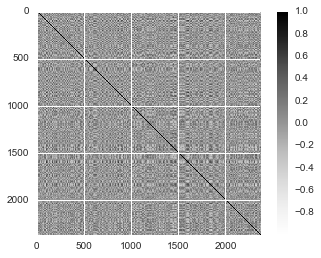

In [351]:
plt.imshow(np.corrcoef(train_x), interpolation='nearest')
plt.colorbar()